In [1]:
import numpy as np
import torch
from torch import nn  
import math
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import AM4std2_sw_cs_LiH4Relu_EN.train_script01 as swcsafen
import AM4std2_sw_cs_LiH4Relu_EY.train_script01 as swcsafey 
import AM4std2_sw_all_LiH4Relu_EN.train_script01 as swafen
import AM4std2_sw_all_LiH4Relu_EY.train_script01 as swafey 

In [3]:
plt.rcParams['font.size'] = '6'

In [4]:
from get_data_sw_AM4_std import get_data_sw_AM4
######################################################
# common functions to split the training and test data
from NNRTMC_utils import  split_train_test_sample, \
draw_batches, data_std_normalization, print_key_results, return_exp_dir

from diag_utils import batch_index_sta_end, pred_NN_batch_sw,\
create_6tiles_sw,regrid_6tile2latlon

In [5]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    # device = 'cpu'
    ######################################################
    # set exp name and runs
    Exp_name = [
        'AM4std2_sw_cs_LiH4Relu_EN',
        'AM4std2_sw_cs_LiH4Relu_EY',
        'AM4std2_sw_all_LiH4Relu_EN'  ,
        'AM4std2_sw_all_LiH4Relu_EY'  ,
    ]
    Exp_name_model_dict = {
        'AM4std2_sw_cs_LiH4Relu_EN': swcsafen,
        'AM4std2_sw_cs_LiH4Relu_EY': swcsafey,
        'AM4std2_sw_all_LiH4Relu_EN'  : swafen,
        'AM4std2_sw_all_LiH4Relu_EY'  : swafey,
    }
    sky_cond = {
        'AM4std2_sw_cs_LiH4Relu_EN'   : 'cs',
        'AM4std2_sw_cs_LiH4Relu_EY'   : 'cs',
        'AM4std2_sw_all_LiH4Relu_EN'  : 'all',
        'AM4std2_sw_all_LiH4Relu_EY'  : 'all',
    }
    work_dir = root+'/work/' 
    # file list AM4 runs 
    filelist = [f'/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/20000101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [6]:
month_sel = None
day_sel = [15,18,21,24,27]
# month_sel = [1]
# day_sel = [15]

In [7]:
# %%time
NN_model = {}
ds_regrid = {} 
for mo in Exp_name:
    ######################################################
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
#     PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
#     restart_data = torch.load(PATH_last)  # load exist results and restart training
#     print(f'load: {PATH_last}')
#     # read training dataset, nor_para, model parameteres
#     nor_para = restart_data['nor_para']
#     model_state_dict = restart_data['model_state_dict'] 
    
#     # read data
#     input_array_ori, output_array_ori, rsdt_array_ori, ds_coords = \
#     get_data_sw_AM4(filelist, condition=sky_cond[mo], 
#                     month_sel = month_sel, day_sel = day_sel, return_coords=True) 
#     # initialize model
#     NN_model[mo] = Exp_name_model_dict[mo].NNRTMC_NN(device, nor_para, A_k, B_k, input_array_ori.shape[1],model_state_dict)  

#     # normalize data via saved nor_para in restart file
#     nor_para, input_array, output_array   = \
#     data_std_normalization(input_array_ori, output_array_ori, nor_para)
#     ######################################################
#     # try NN on test dataset  
#     predi, eng_err = \
#     pred_NN_batch_sw(input_array, output_array, rsdt_array_ori, NN_model[mo], nor_para, device)
#     error = predi - output_array_ori*rsdt_array_ori[:,None]
#     predi[:,3:] = predi[:,3:]*86400 # HR K/s >> K/day
#     error[:,3:] = error[:,3:]*86400 # HR K/s >> K/day
#     # create 6-tile files for output and regrid 
#     NN_output_name = 'NN_20000101.fluxes' 
#     subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
#     var_list = create_6tiles_sw(ds_coords, predi, error, eng_err, exp_dir, NN_output_name)
#     del predi, eng_err, error
#     regrid_file_path = regrid_6tile2latlon(var_list, exp_dir, root, NN_output_name)
    regrid_file_path = exp_dir+f'/NN_pred/NN_20000101.fluxes.nc'
    print(regrid_file_path)
    # open regridded file
    with  xr.open_dataset(regrid_file_path) as ds:
        ds_regrid[mo] = ds.load().rename({'grid_yt':'lat', 'grid_xt':'lon'}) 


/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_sw_cs_LiH4Relu_EN/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_sw_cs_LiH4Relu_EY/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_sw_all_LiH4Relu_EN/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_sw_all_LiH4Relu_EY/NN_pred/NN_20000101.fluxes.nc


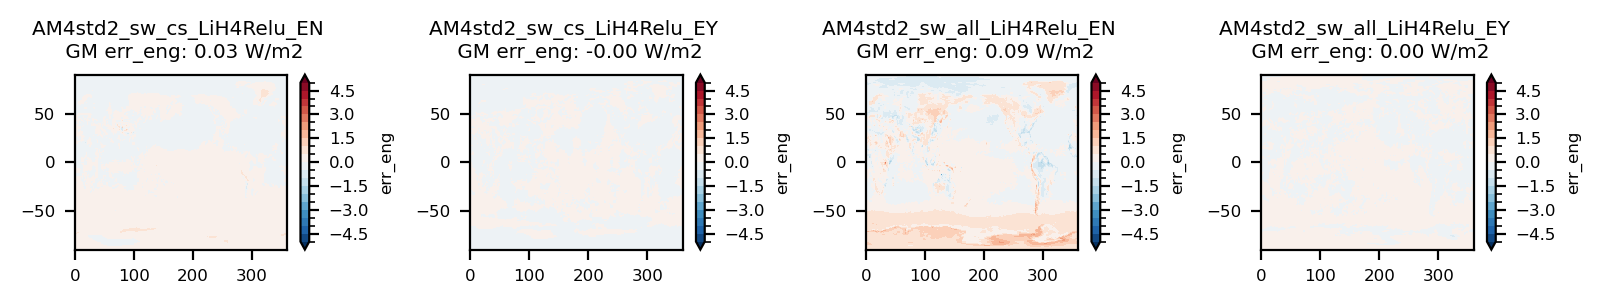

In [8]:
fig, axs = plt.subplots(nrows=1,ncols=4,figsize=(8,1.5),dpi=200)
axs = axs.flatten() 
for i, mo in enumerate(Exp_name):
    ds_plot = ds_regrid[mo]
    var_name = 'err_eng'
    level = np.array([-4,-2,-1,-0.5,-0.2,0.2,0.5,1,2,4 ])
    level = np.arange(-5,5.1,0.5)
    # if sky_cond[mo] == 'af':  level = level*2
    ax=axs[i]
    da = ds_plot[var_name].mean('time')
    da.plot(ax=ax, levels=level, extend='both') 
    ax.set_title(f'{mo} \n GM err_eng: {global_mean_xarray(da).values:4.2f} W/m2') 
    ax.set(xlabel=None,ylabel=None)
    # plt.title(mo)
fig.tight_layout()

In [9]:
month_sel=[1,2,3,4,5,6,7,8,9,10,11,12]
day_sel=[15,18,21,24,27]

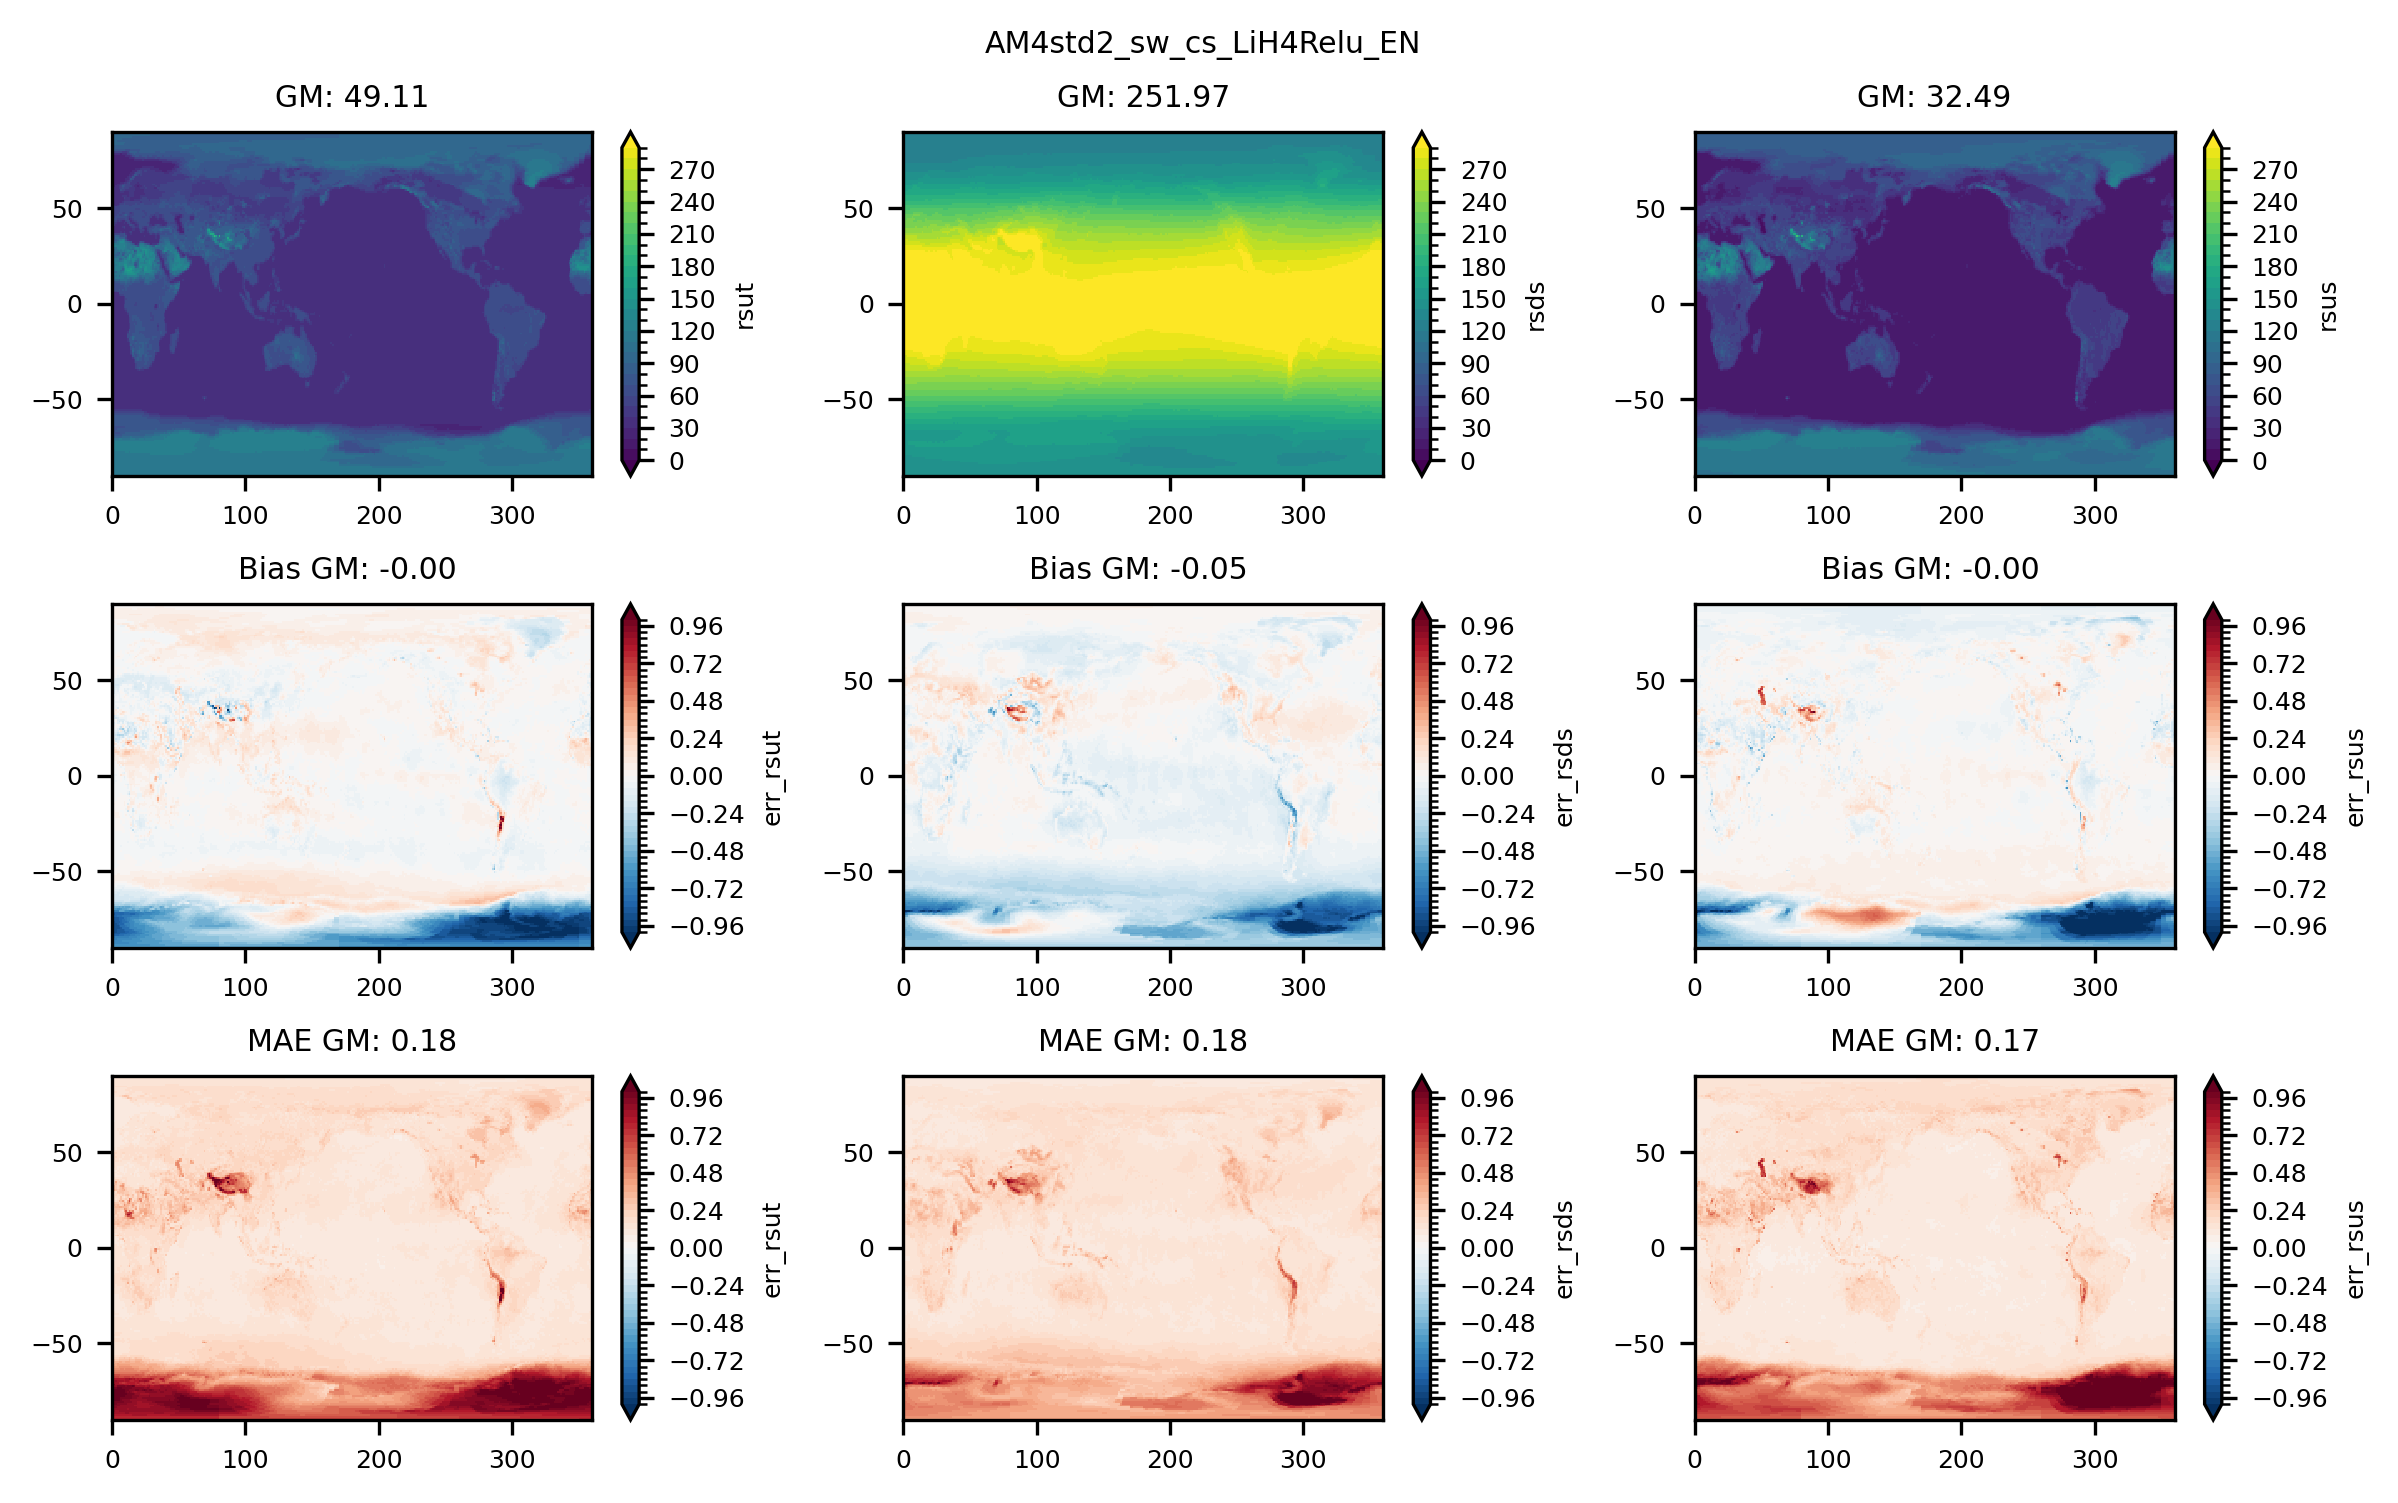

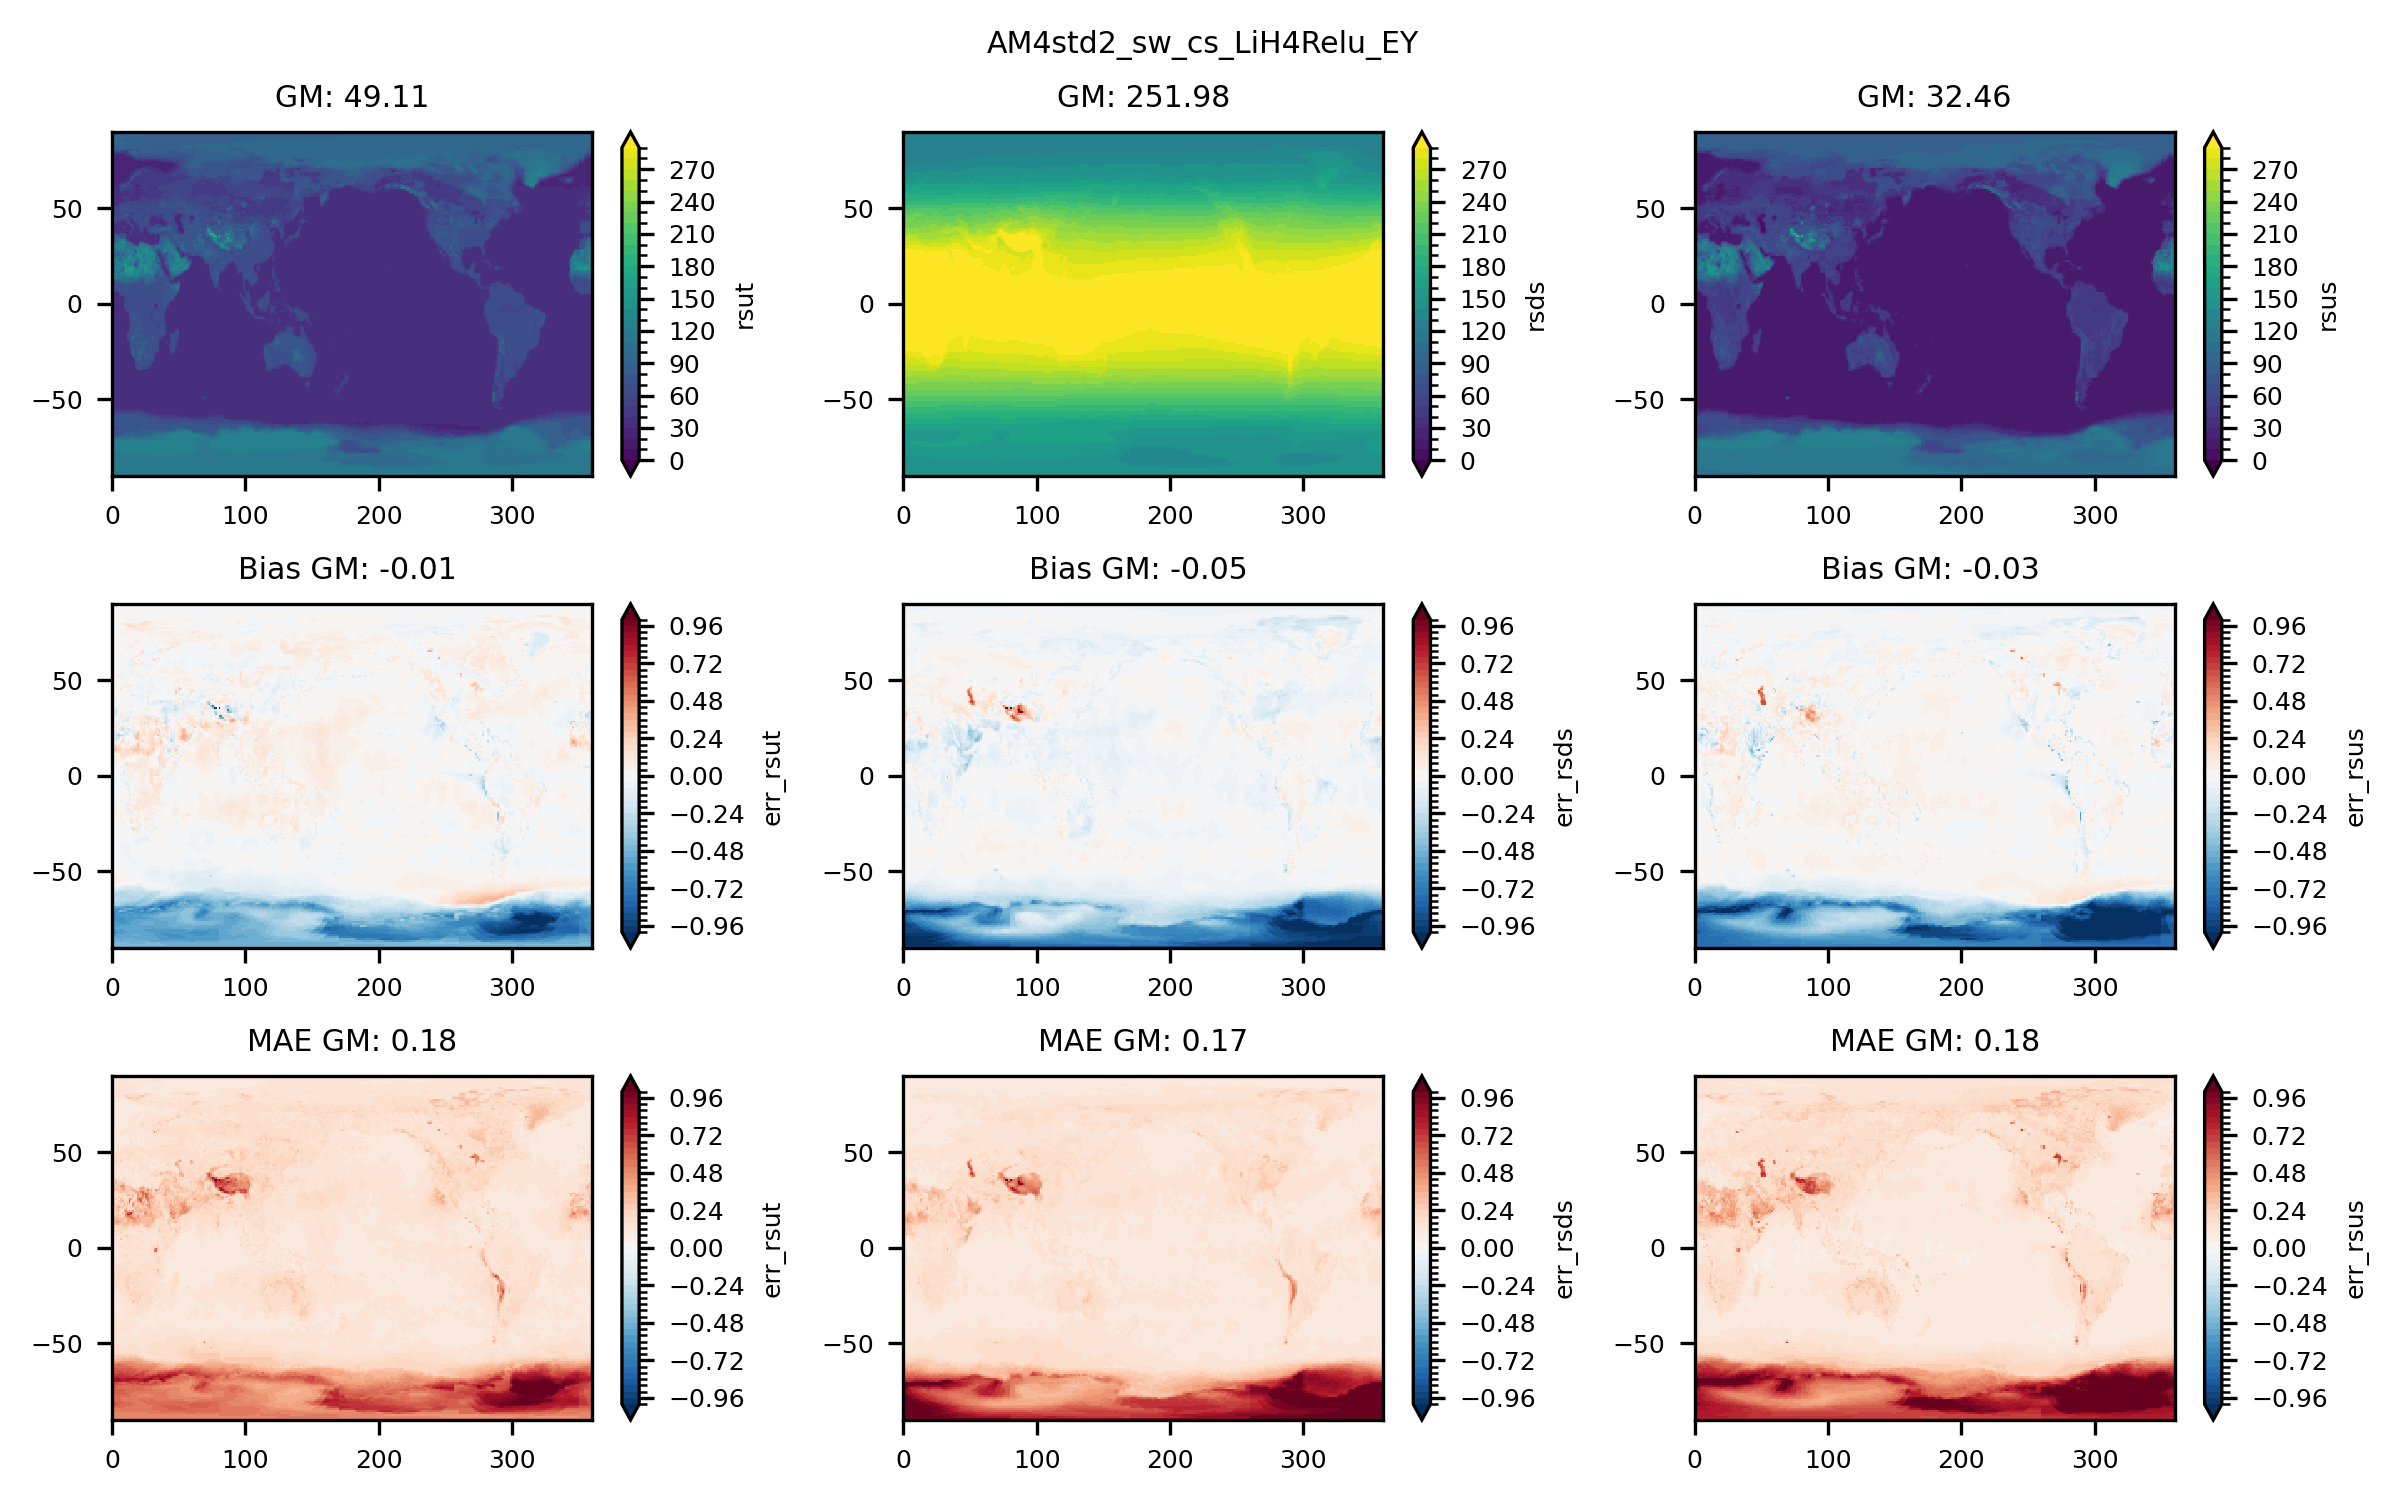

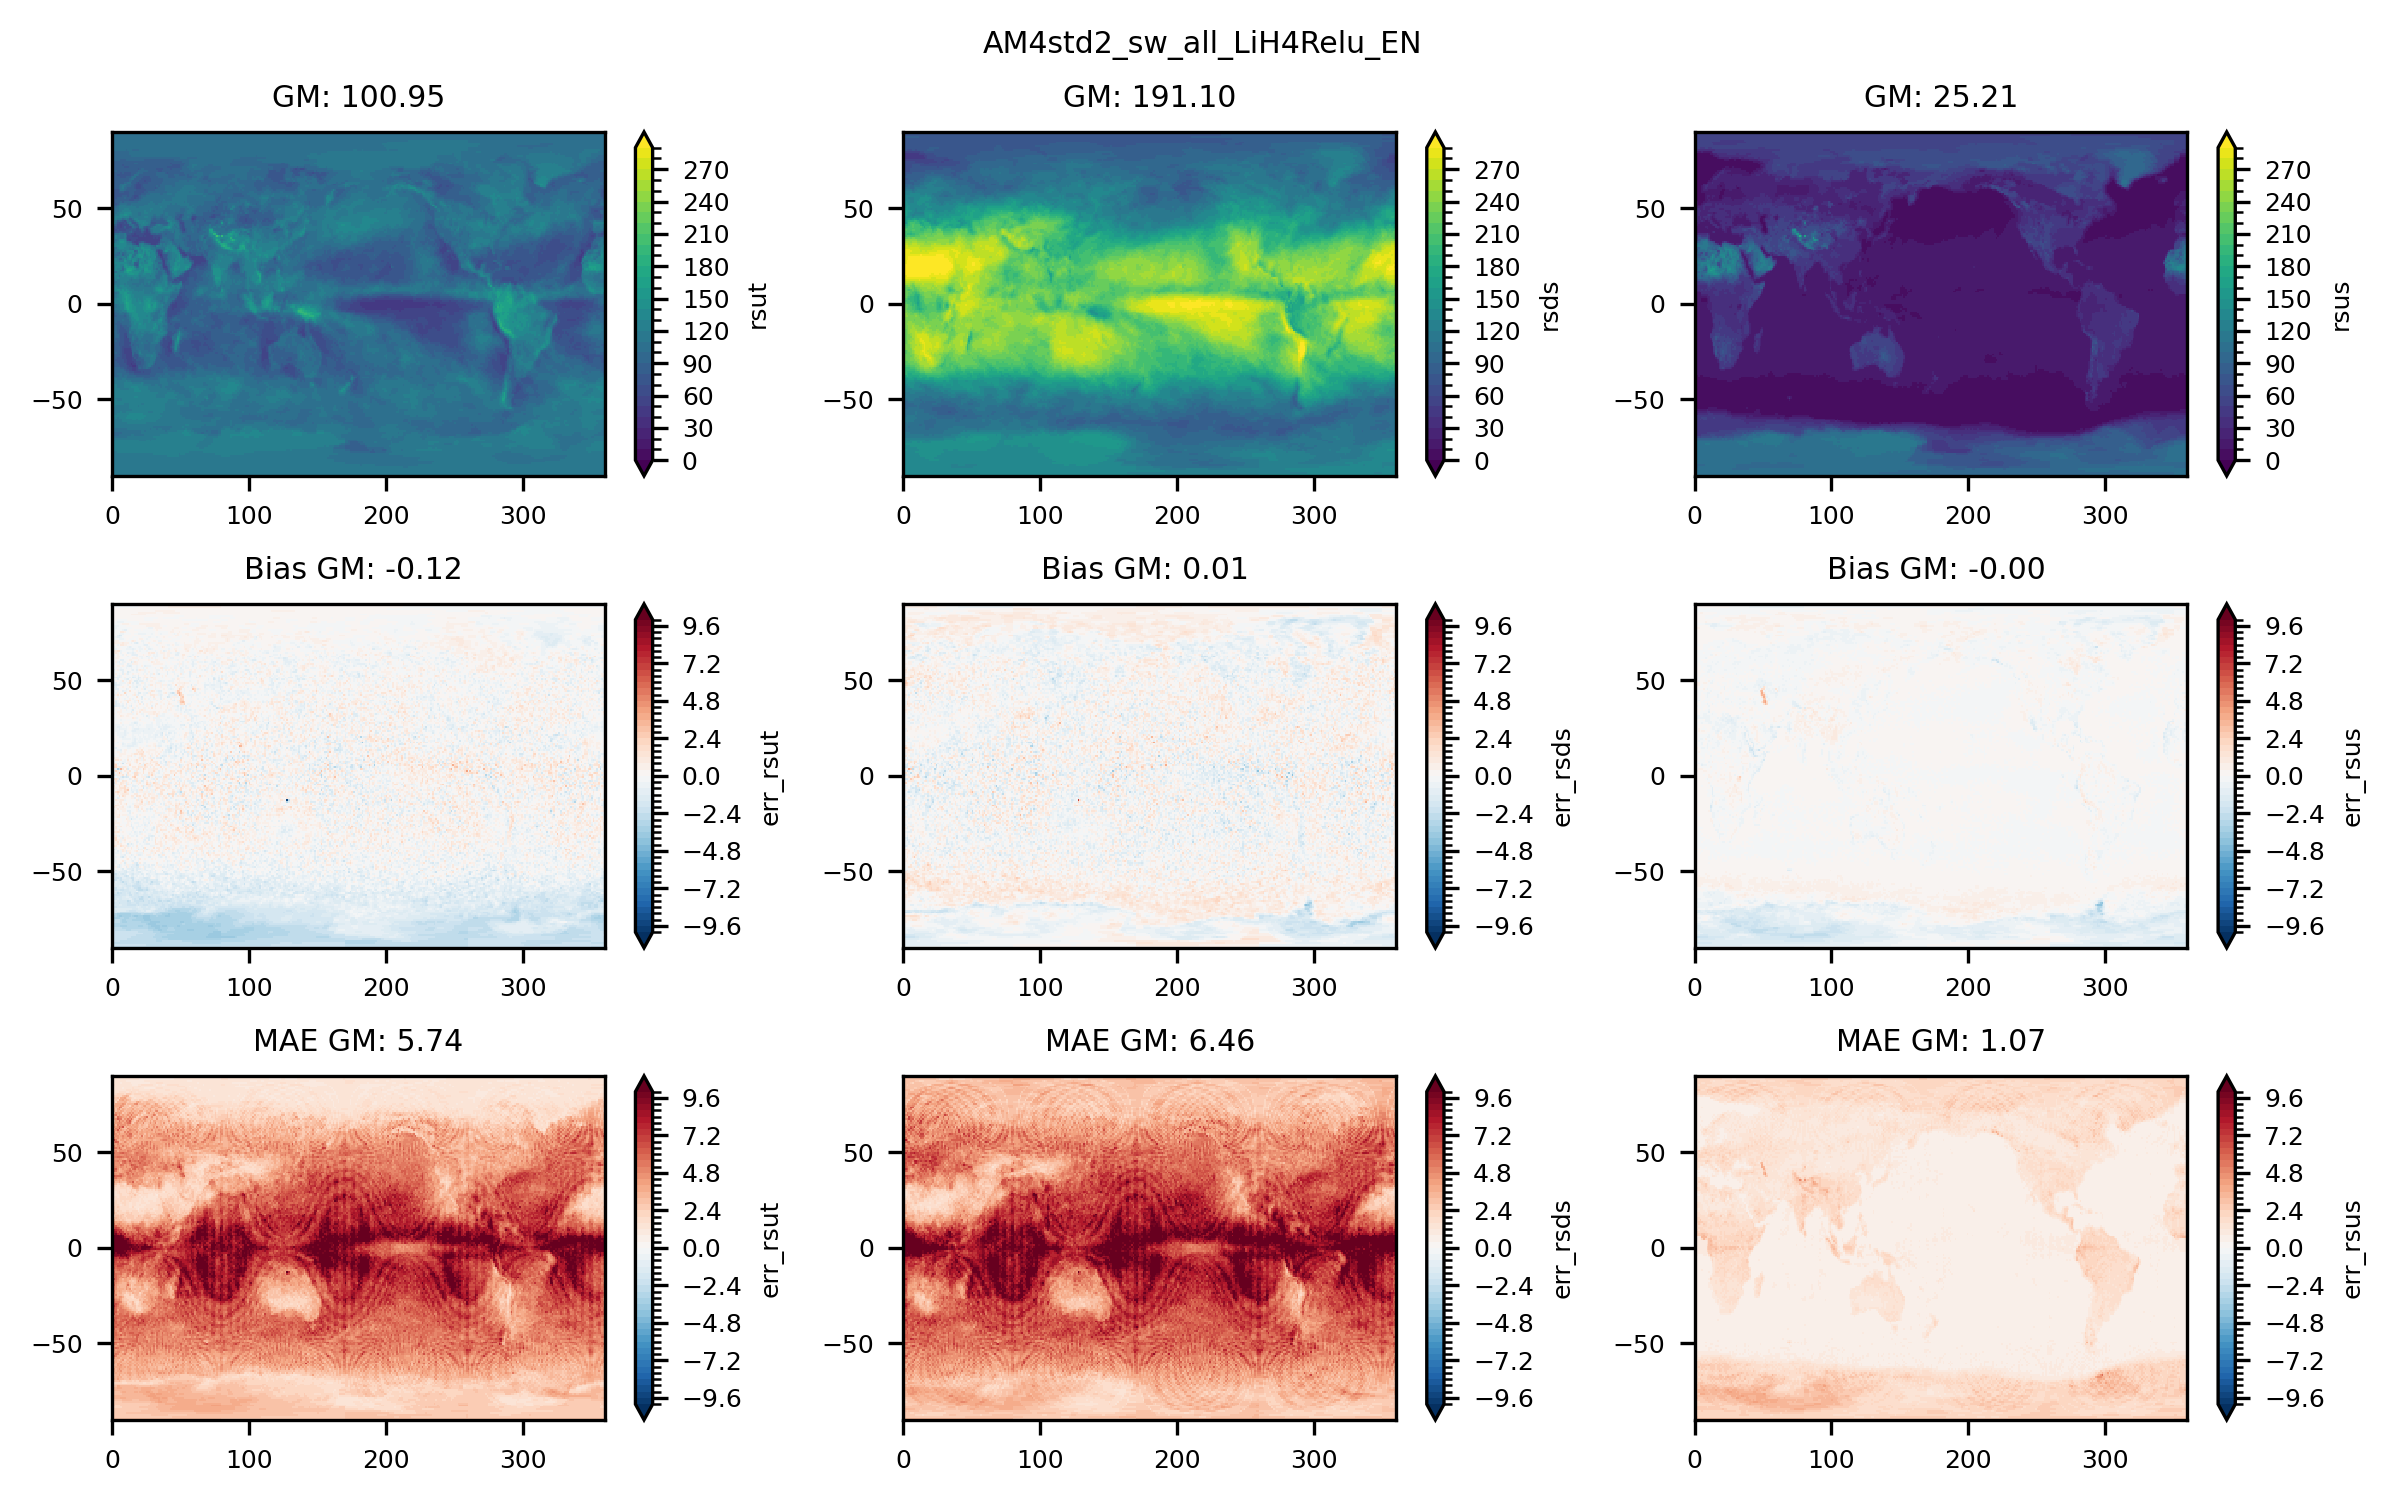

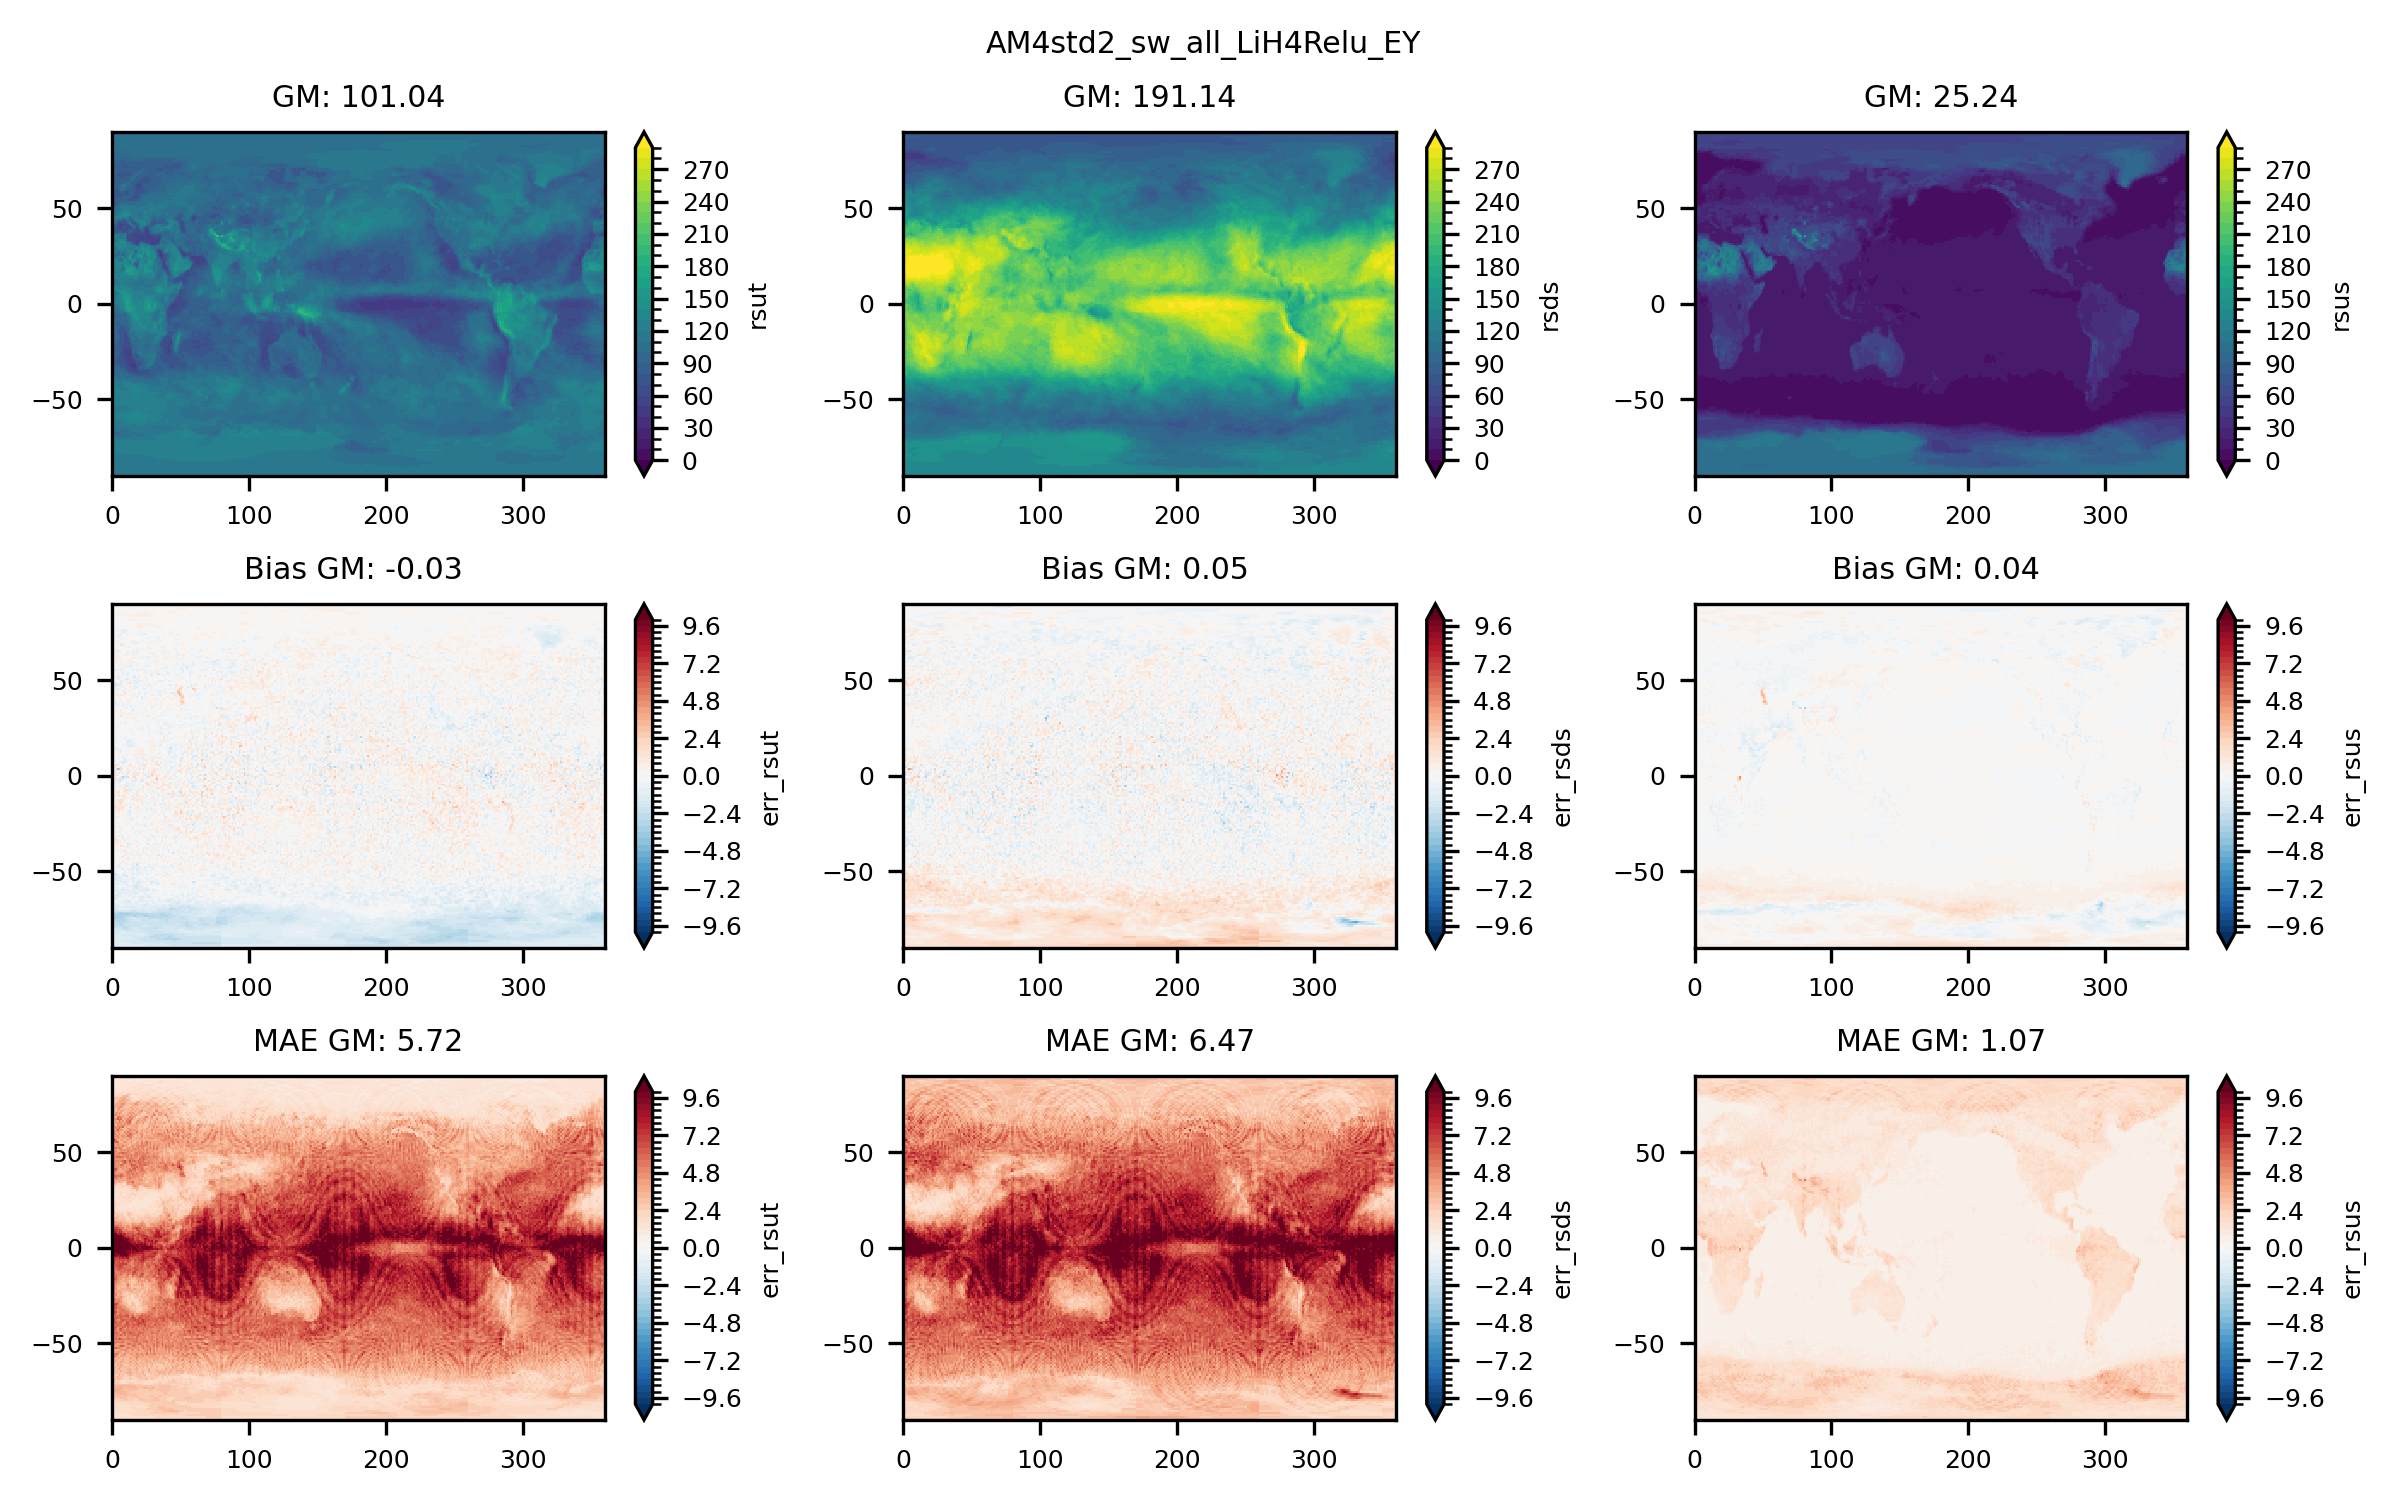

In [10]:
for mo in Exp_name:
    # mo = 'sw_af_Li5Relu_EY'
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_plot = ds_regrid[mo].isel(time=time_sel)
    ds_plot = ds_regrid[mo]
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(8,5),dpi=300)
    axs = axs.flatten()
    var1 = ['rsut','rsds','rsus']
    level = np.arange(0,300,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
    # level = np.array([-16, -8, -4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4,8,16])
    level = np.arange(-5,5.1,0.2)/5
    if sky_cond[mo] == 'all':  level = level*10
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f} ')
                     # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}')
                     # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()

In [11]:
print('GM: Bias, MAE, RMSE')
for mo in Exp_name:
    print(mo)
    ds_plot = ds_regrid[mo]
    for i in range(3): 
        da = global_mean_xarray(ds_plot['err_'+var1[i]])
        Bias = da.mean()
        MAE  = abs(da).mean()
        RMSE = ((da**2).mean())**0.5
        print(f'err_{var1[i]}: {Bias.values:4.2f}, {MAE.values:4.2f}, {RMSE.values:4.2f},') 

GM: Bias, MAE, RMSE
AM4std2_sw_cs_LiH4Relu_EN
err_rsut: -0.00, 0.02, 0.03,
err_rsds: -0.05, 0.06, 0.08,
err_rsus: -0.00, 0.03, 0.05,
AM4std2_sw_cs_LiH4Relu_EY
err_rsut: -0.01, 0.02, 0.04,
err_rsds: -0.05, 0.05, 0.07,
err_rsus: -0.03, 0.04, 0.06,
AM4std2_sw_all_LiH4Relu_EN
err_rsut: -0.12, 0.20, 0.27,
err_rsds: 0.01, 0.13, 0.16,
err_rsus: -0.00, 0.05, 0.07,
AM4std2_sw_all_LiH4Relu_EY
err_rsut: -0.03, 0.13, 0.17,
err_rsds: 0.05, 0.15, 0.19,
err_rsus: 0.04, 0.07, 0.08,


## plot error for all columns

In [12]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

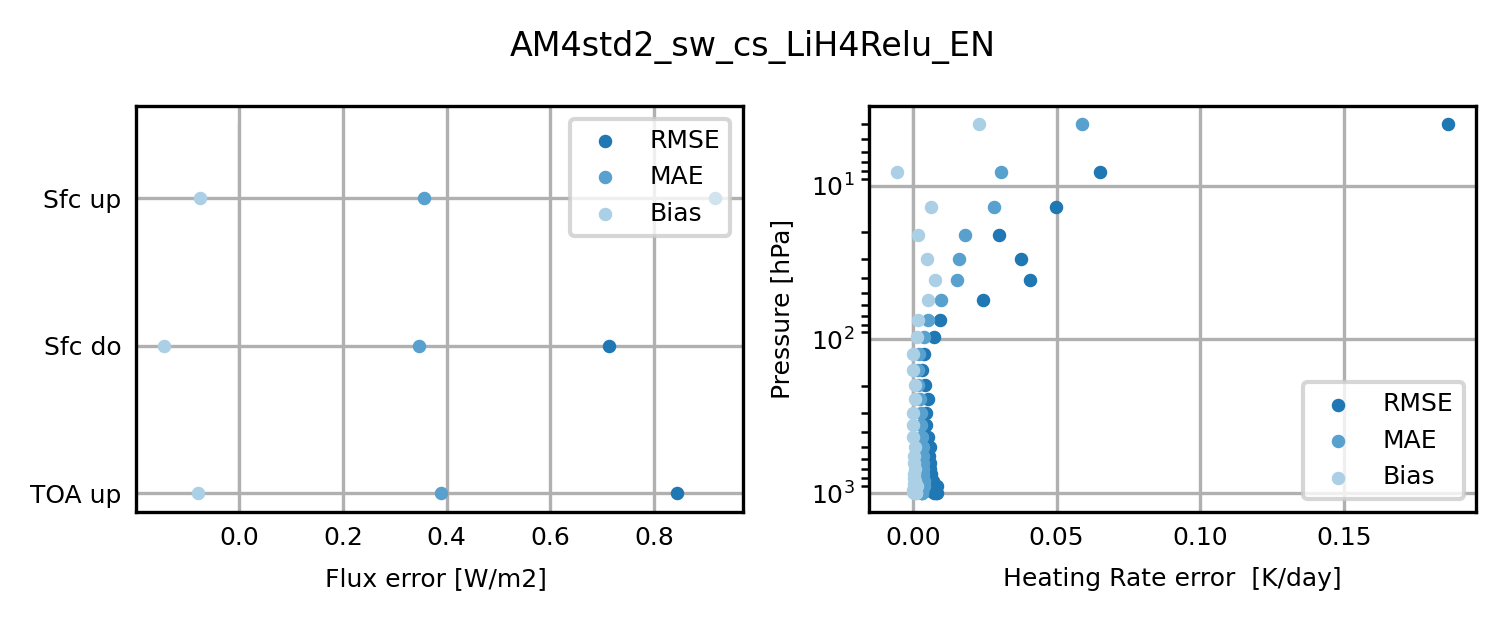

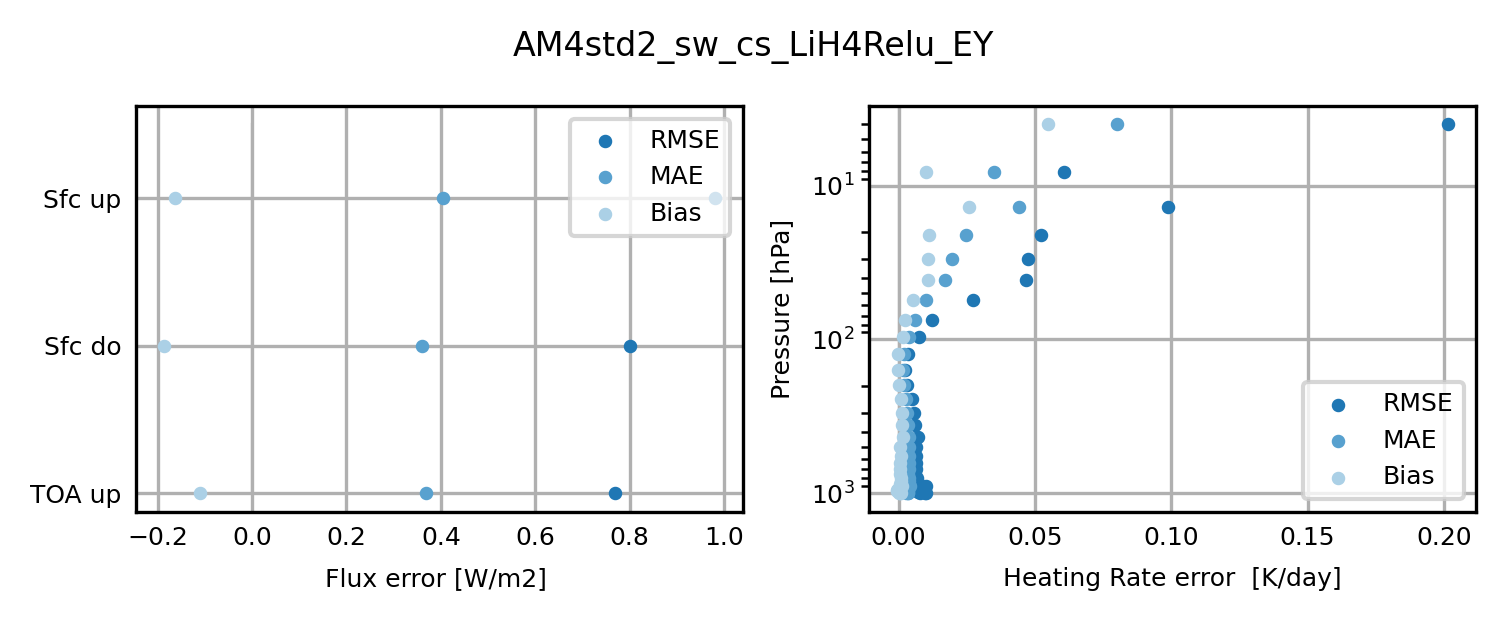

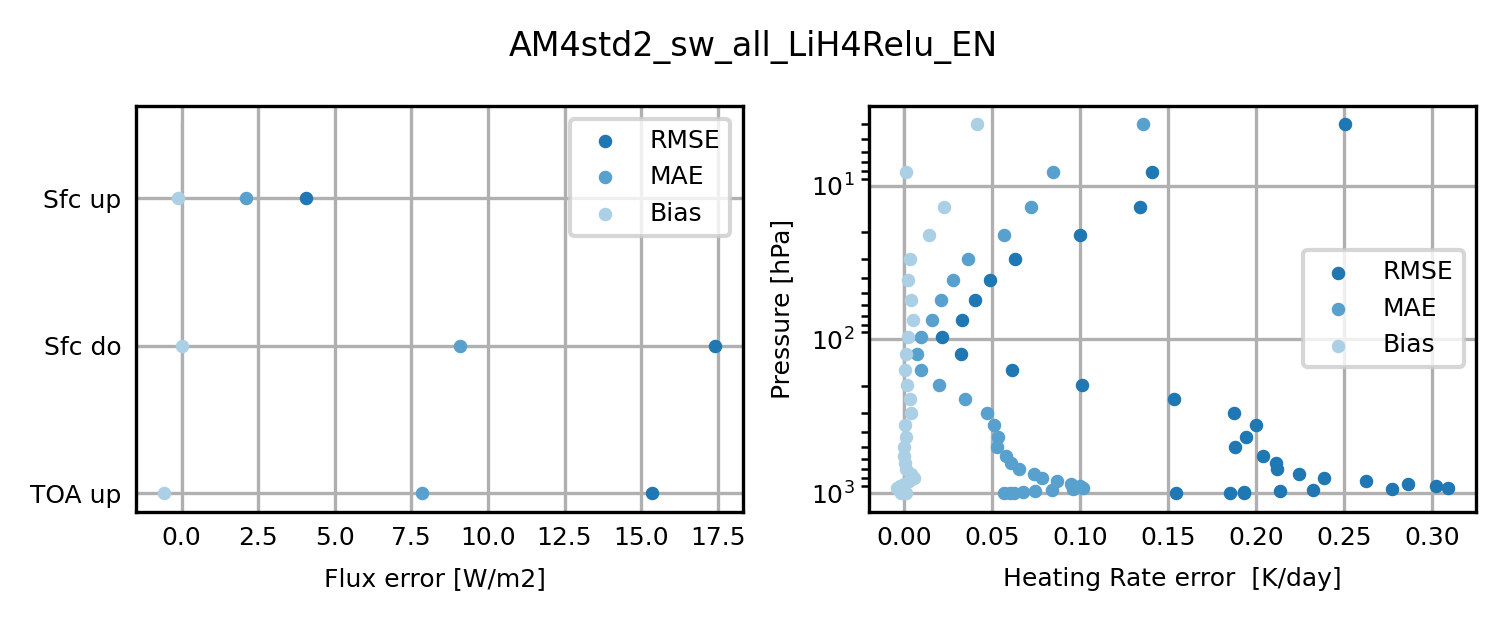

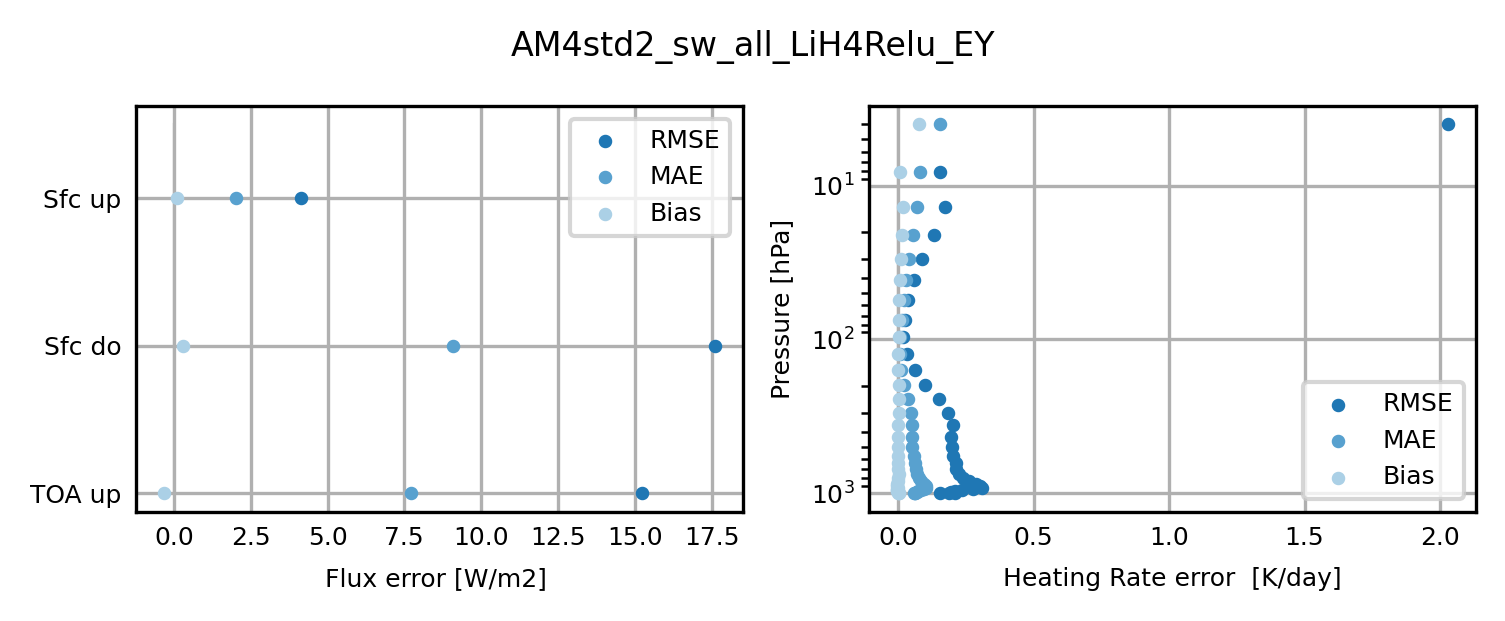

In [13]:
error = {}
day_inds = {} 
for i, mo in enumerate(Exp_name): 
    ds = ds_regrid[mo]
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_plot = ds_regrid[mo].isel(time=time_sel)
    rsut_nn = ds_plot['rsut'].stack(txy=("time", "lat", "lon")).values
    rsut = rsut_nn-ds_plot['err_rsut'].stack(txy=("time", "lat", "lon")).values
    day_ind = np.argwhere( ~np.isclose(rsut, 0, atol=1e-1)).squeeze() 
    day_inds[mo] = day_ind
    err_var = [ 'err_rsut','err_rsds','err_rsus','err_tntrs' ] 
    err = [ds_plot[_].stack(txy=("time", "lat", "lon")).values[None,:] for _ in err_var[:3]]
    err.append(ds_plot['err_tntrs'].stack(txy=("time", "lat", "lon")).values)
    error[mo] = np.concatenate(err).T
    RMSE = ((error[mo][day_ind]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo][day_ind]).mean(axis=0)
    bias = error[mo][day_ind].mean(axis=0)
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=300) 
    axs=axs.flatten() 
    ax3=axs[0] # error
    ax4=axs[1] # error 

    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'TOA up','Sfc do','Sfc up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m2] ')
#     ax3.set_xlim([-0.1,1.2])

    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

## exclude large energe error columns

In [14]:
eng_err_arr = {}
for i, mo in enumerate(Exp_name):  
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_plot = ds_regrid[mo].isel(time=time_sel)
    day_ind = day_inds[mo]
    eng_err = ds_plot['err_eng'].stack(txy=("time","lat", "lon")).values
    eng_err_arr[mo] = eng_err
    rd_id_more = np.random.randint(0,eng_err[day_ind].shape[0],10000) 
    rd_id_more = day_ind[rd_id_more]
    ind_small_eng_err = np.argwhere(abs(eng_err[rd_id_more])<1)
    ind_small_eng_err = rd_id_more[ind_small_eng_err] 
    print(f'{mo} good ratio: {ind_small_eng_err.shape[0]/day_ind.shape[0]:4.3f}')
    rd_id_more = np.random.randint(0,ind_small_eng_err.shape[0],10000) 
    ind_small_eng_err = ind_small_eng_err[rd_id_more] 
    RMSE = ((error[mo][ind_small_eng_err,:]**2).mean(axis=0).squeeze())**0.5
    MAE  = abs(error[mo][ind_small_eng_err,:]).mean(axis=0).squeeze()
    bias = error[mo][ind_small_eng_err,:].mean(axis=0).squeeze() 
    print(RMSE[:3],MAE[:3],bias[:3])
    # rd_id_more = np.random.randint(0,error[mo].shape[0],1000000)
    RMSE = ((error[mo][rd_id_more,:]**2).mean(axis=0).squeeze())**0.5
    MAE  = abs(error[mo][rd_id_more,:]).mean(axis=0).squeeze()
    bias = error[mo][rd_id_more,:].mean(axis=0).squeeze() 
    print(RMSE[:3],MAE[:3],bias[:3])

AM4std2_sw_cs_LiH4Relu_EN good ratio: 0.001
[0.7018436  0.6130992  0.79181236] [0.33423844 0.30273145 0.31125948] [-0.05470804 -0.11500442 -0.05868232]
[1.188363   0.97911656 0.761498  ] [0.92249924 0.6290171  0.5447111 ] [-0.42307022 -0.4184078   0.11311709]
AM4std2_sw_cs_LiH4Relu_EY good ratio: 0.001
[0.7791004 0.8034135 1.005891 ] [0.3726785  0.36192438 0.4132826 ] [-0.11402356 -0.18111826 -0.1674776 ]
[1.2347353 1.0949231 1.5585027] [0.92702854 0.75975007 1.1151819 ] [-0.5122501  -0.60189754 -0.74228835]
AM4std2_sw_all_LiH4Relu_EN good ratio: 0.000
[14.142341  15.647362   2.6124082] [6.6606593 7.529724  1.4025509] [-0.11802229  0.01705995 -0.03719908]
[10.297897 10.763003  7.075095] [7.93565  7.331304 5.084625] [-6.9170117  1.3503722 -2.1583412]
AM4std2_sw_all_LiH4Relu_EY good ratio: 0.001
[14.886552  17.05138    3.9576435] [7.742988  9.122219  2.0772986] [-0.15061904  0.1286308   0.11665038]
[11.57929  14.424164  5.941933] [6.636886 8.947021 3.676116] [-3.4947977  4.5698223  1.363

In [15]:
eng_err

array([1.0226059, 1.0226059, 1.0226059, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

# energy check

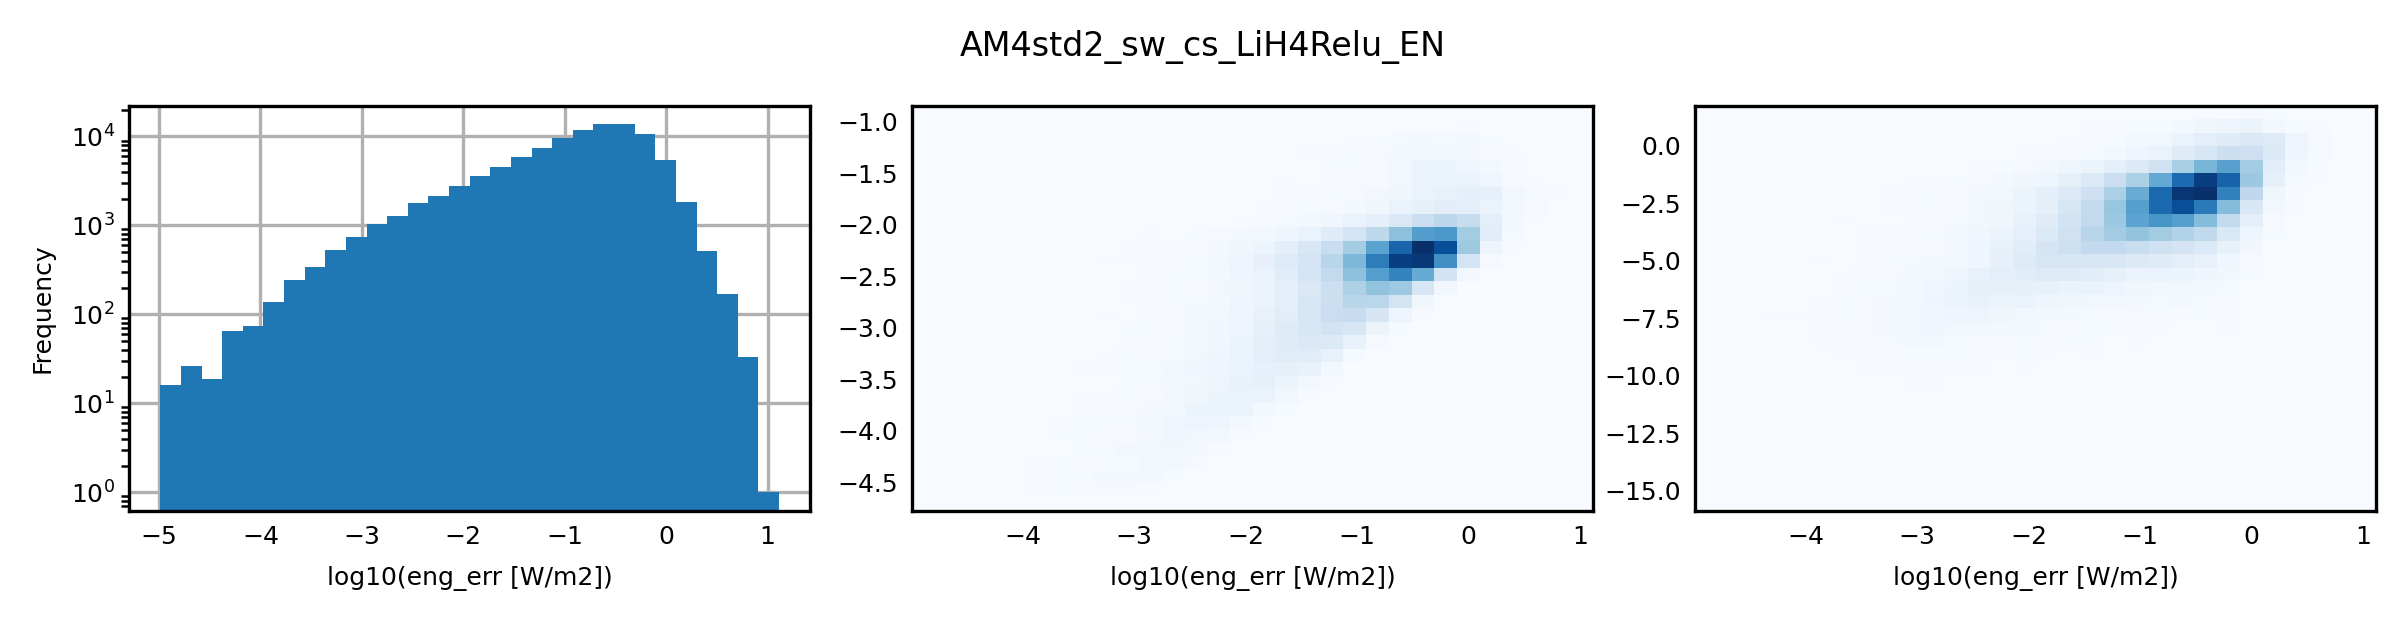

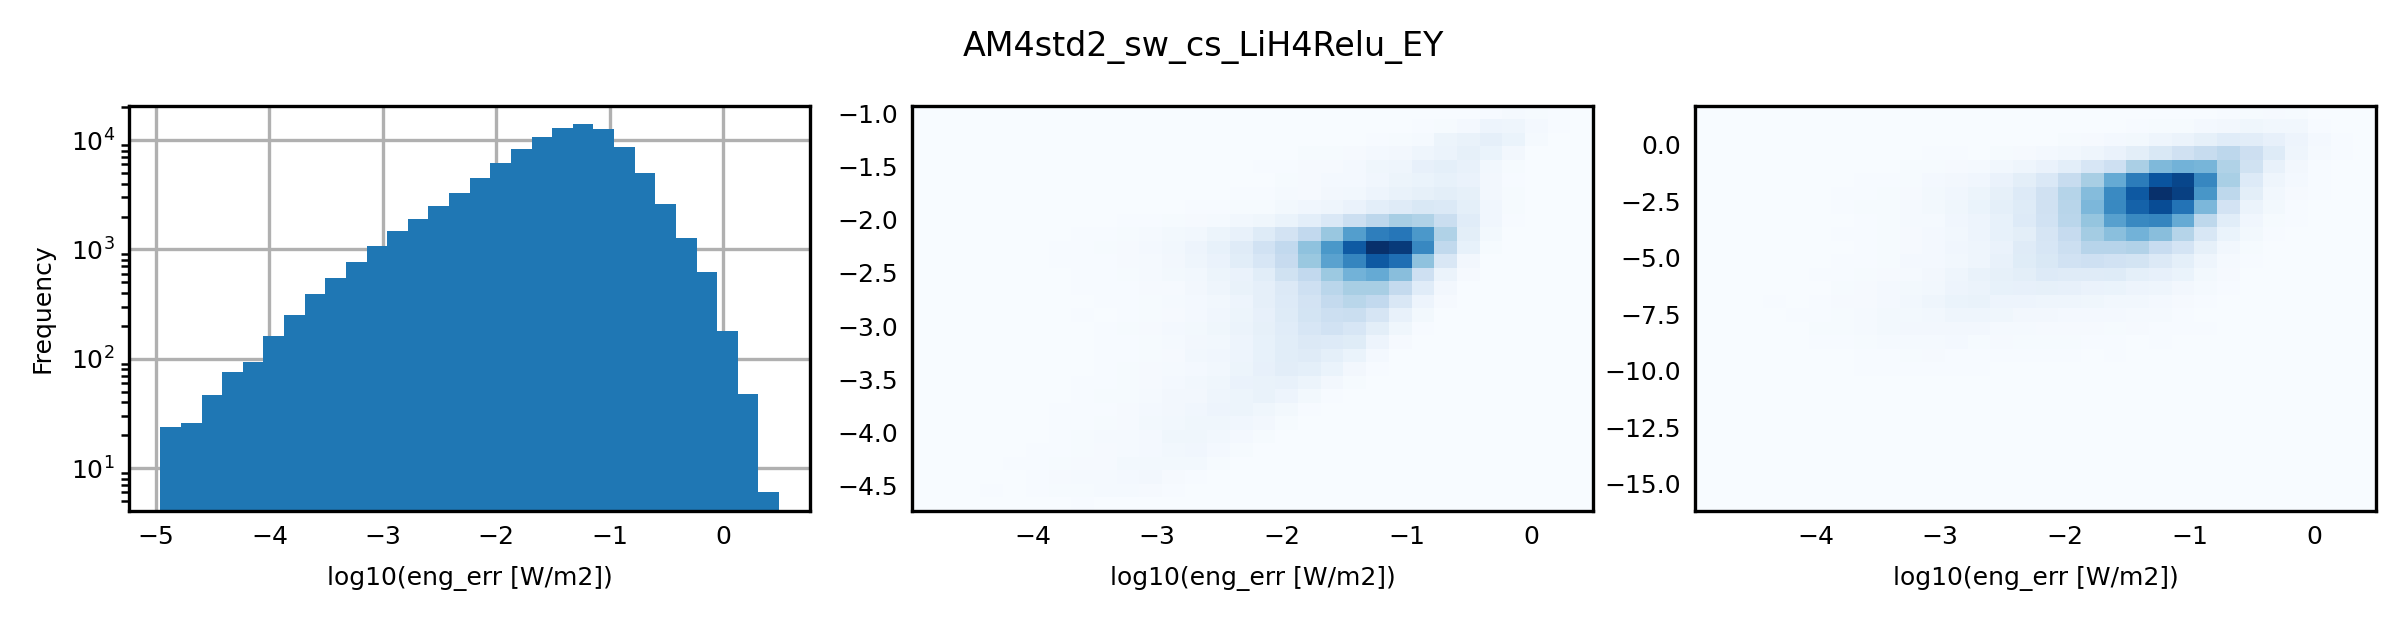

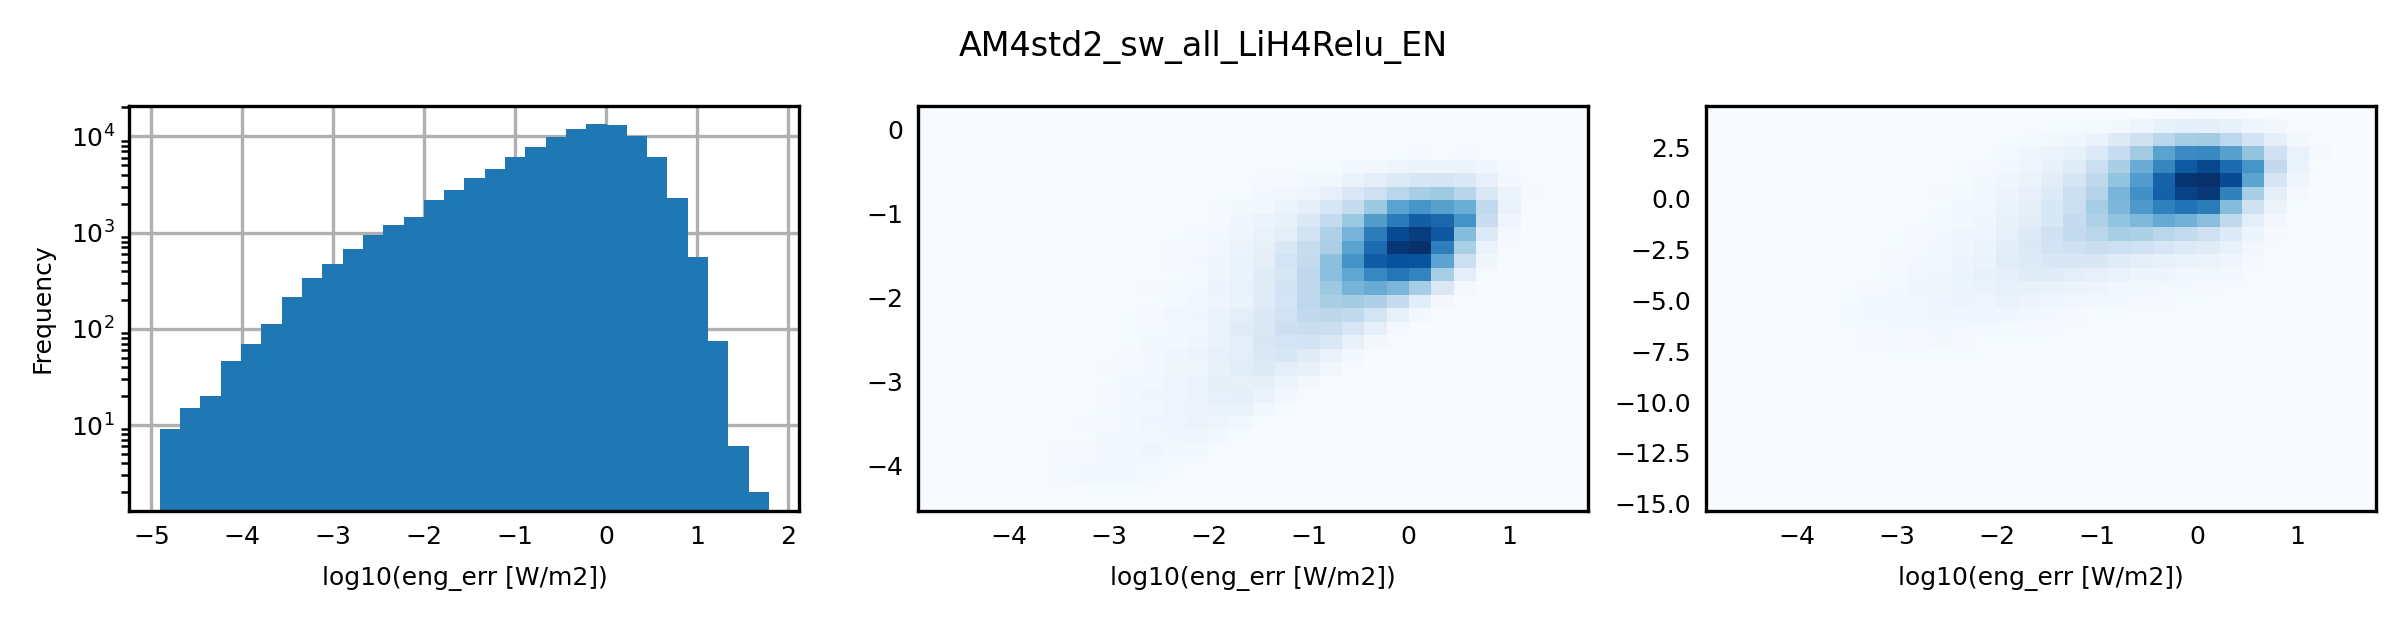

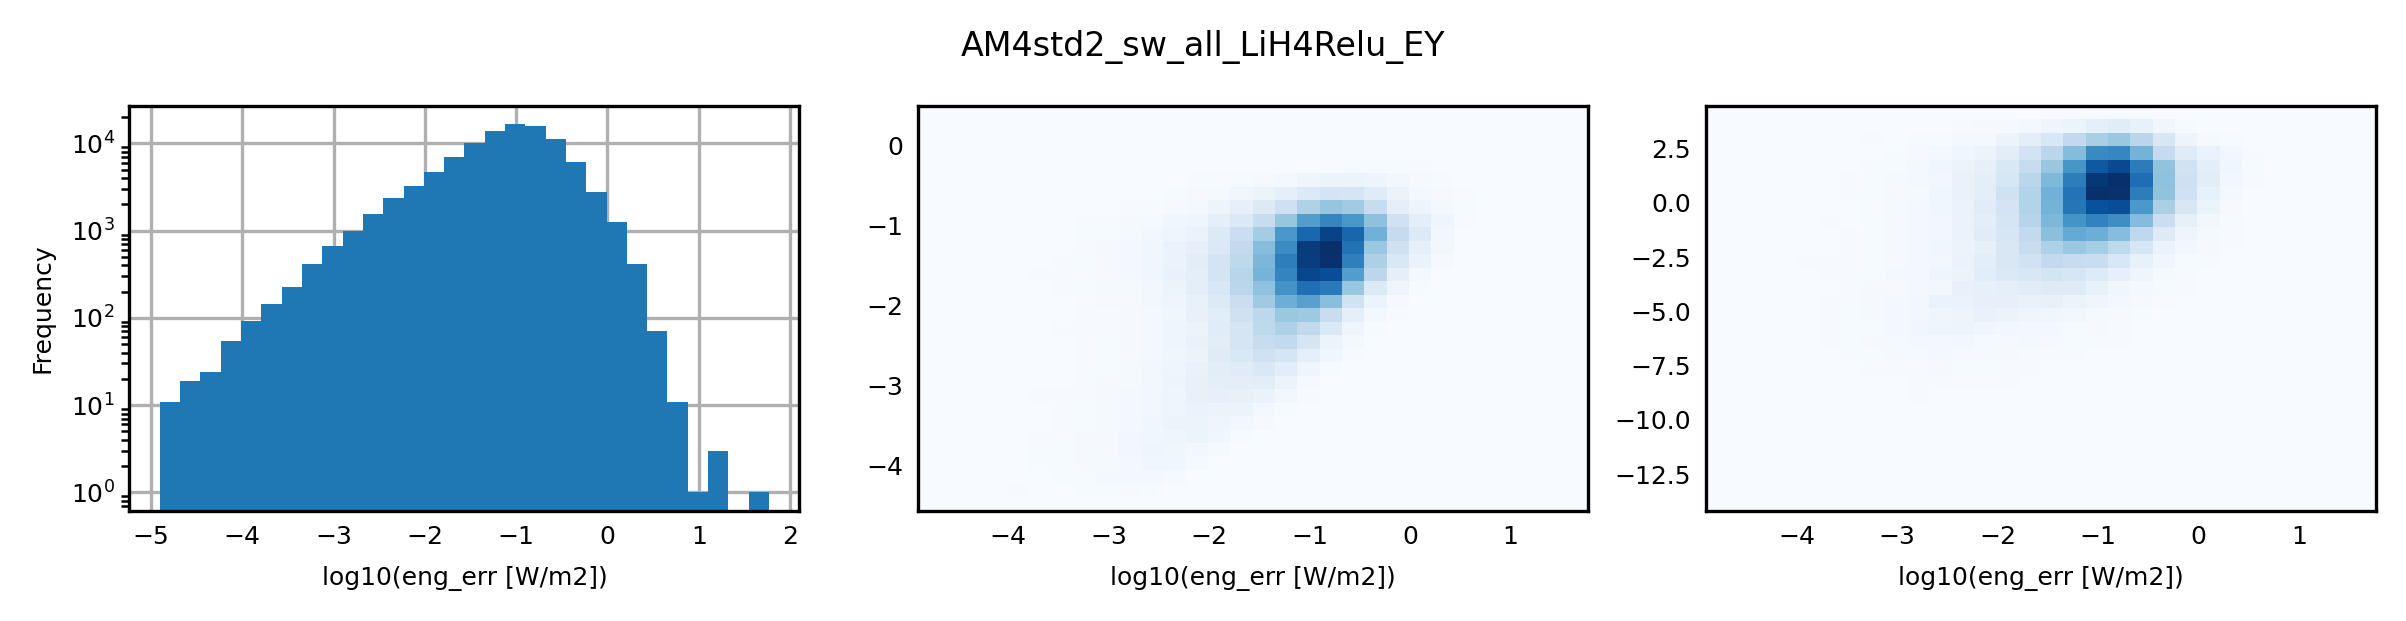

In [16]:
var_arr = {}
for i, mo in enumerate(Exp_name): 
    day_ind = day_inds[mo] 
    rd_id_more = np.random.randint(0,day_ind.shape[0],100000)
    rd_id_more = day_ind[rd_id_more]
    
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_data = ds_regrid[mo].isel(time=time_sel)
    eng_err = eng_err_arr[mo][rd_id_more]
    vars_var = [ 'rsut','rsds','rsus','tntrs' ] 
    var = [ds[_].stack(txy=("time","lat", "lon")).values[None,:] for _ in vars_var[:3]]
    var.append(ds[vars_var[3]].stack(txy=("time","lat", "lon")).values)
    var_arr[mo] = np.concatenate(var).T 
    
    std_nor = var_arr[mo][rd_id_more].std(axis=0)[None,:] 
    pred_err_ind = abs(error[mo][rd_id_more]/std_nor).mean(axis=1)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300) 
    axs= axs.flatten()
    ax = axs[0]
    eng_err_log = np.log(abs(eng_err)+1e-5)/np.log(10)
    pred_err_ind_log = np.log(abs(pred_err_ind)+1e-5)/np.log(10)
    ax.hist(eng_err_log,bins=30)
    ax.set_yscale('log')
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('Frequency')
    ax = axs[1]
    ax.hist2d(eng_err_log,pred_err_ind_log, bins=30) 
    ax.set_xlabel('log10(eng_err [W/m2])')
    # ax.set_ylabel('err index')
    ax = axs[2]
    plt.hist2d(eng_err_log,np.log(abs(error[mo][rd_id_more,0]+1e-5)/np.log(10)), bins=30) 
    ax.set_xlabel('log10(eng_err [W/m2])')
    # ax.set_ylabel('rlut_err W/m2')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

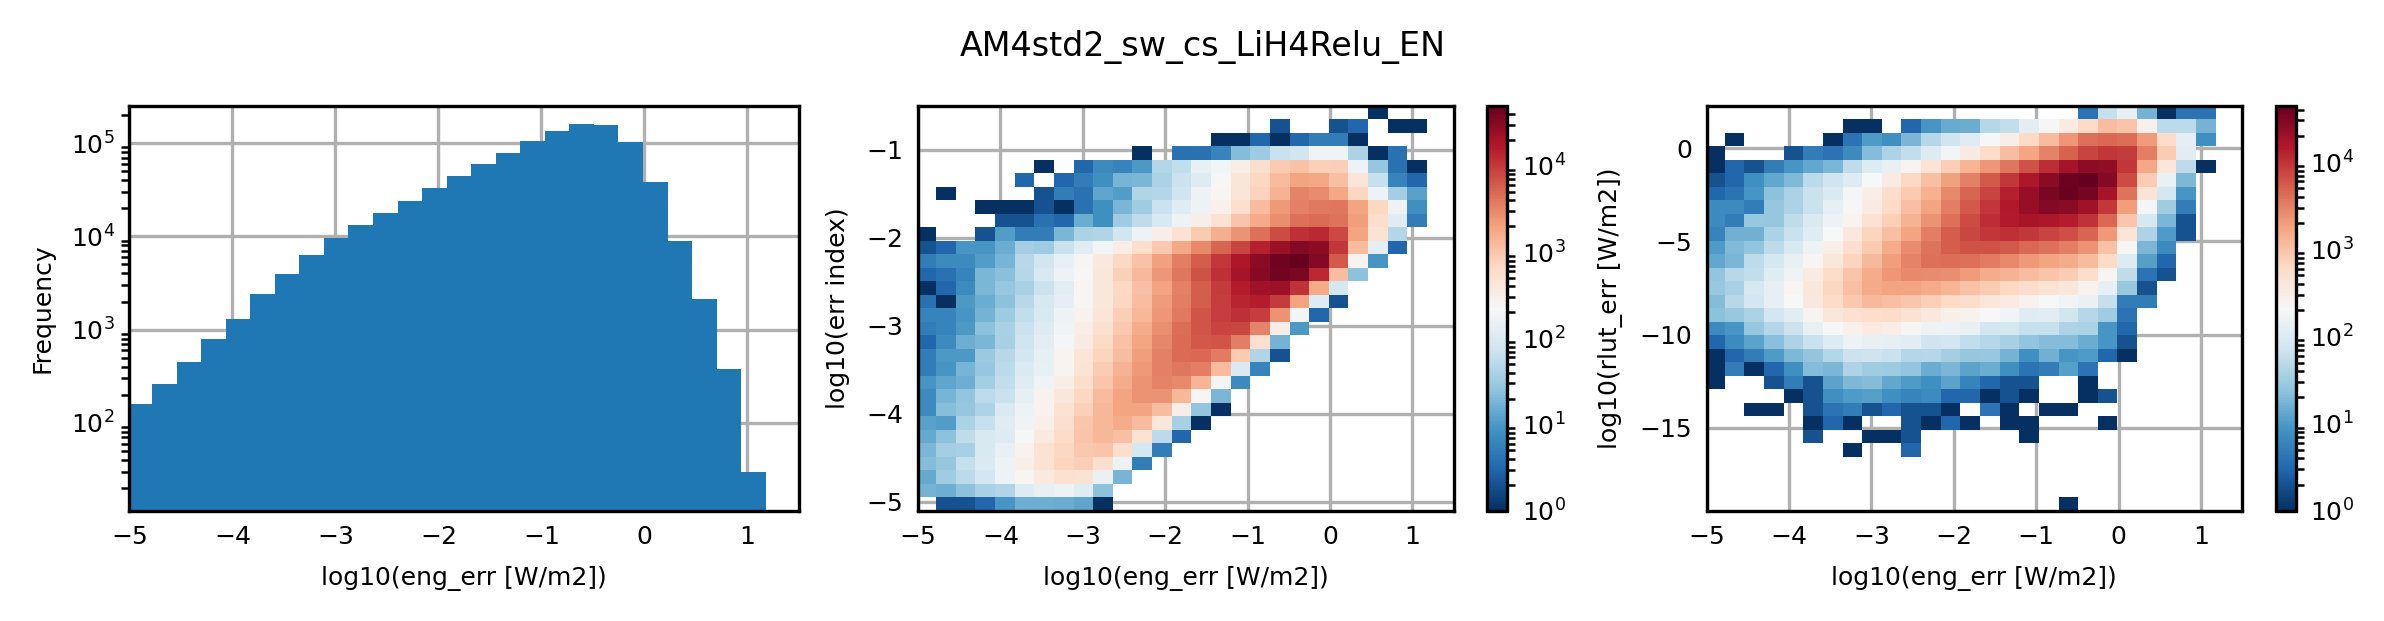

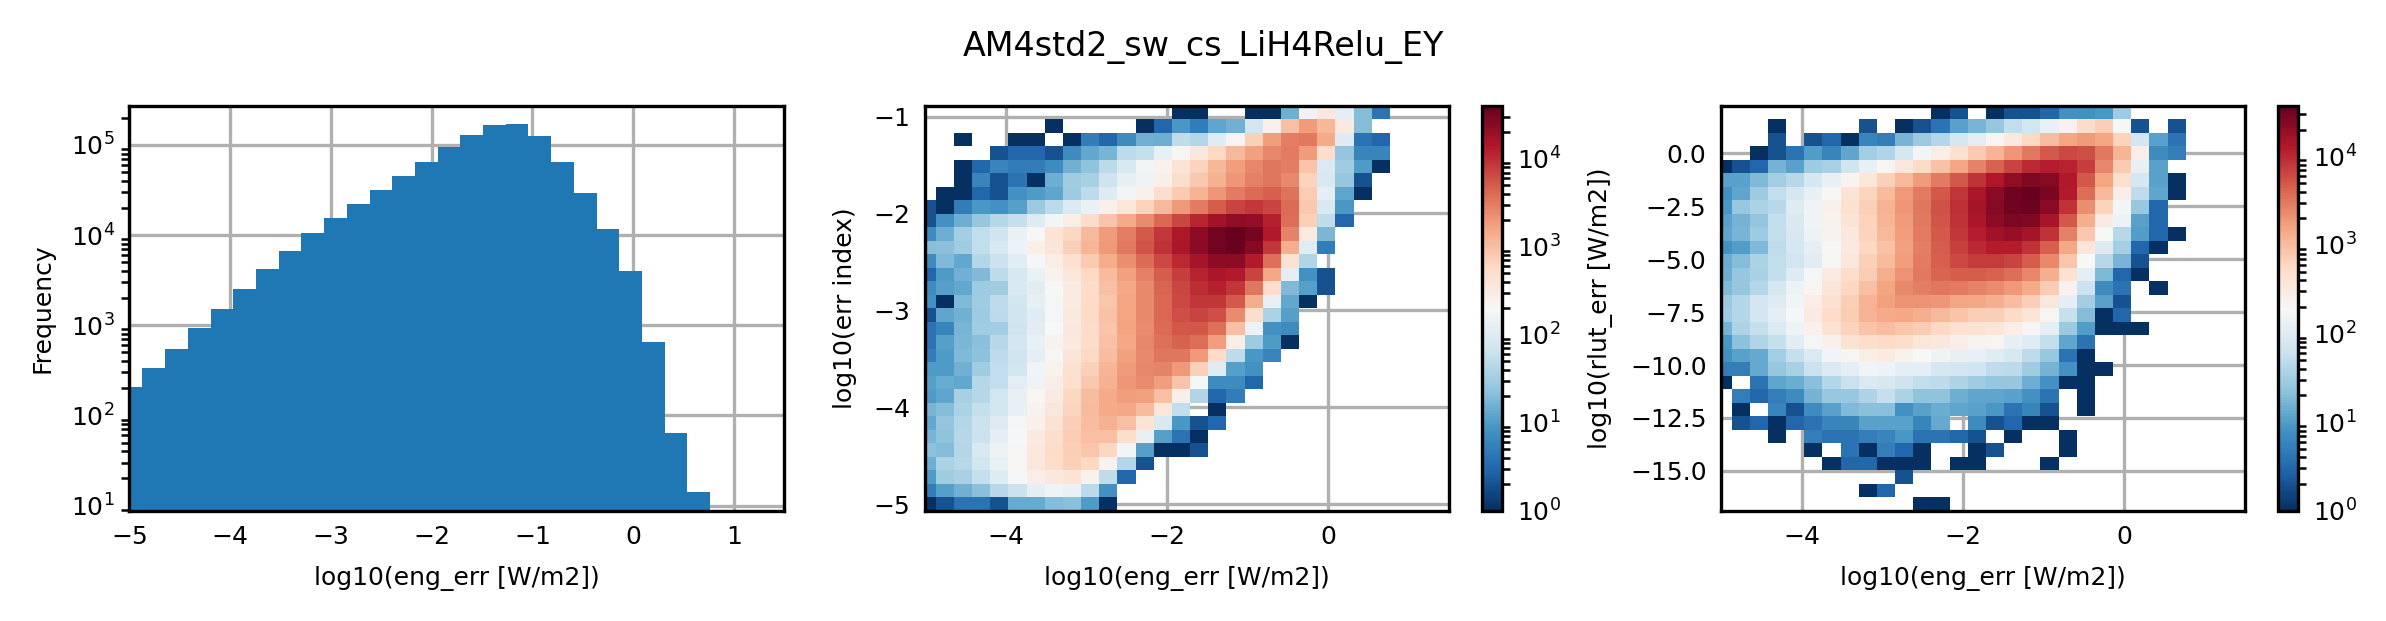

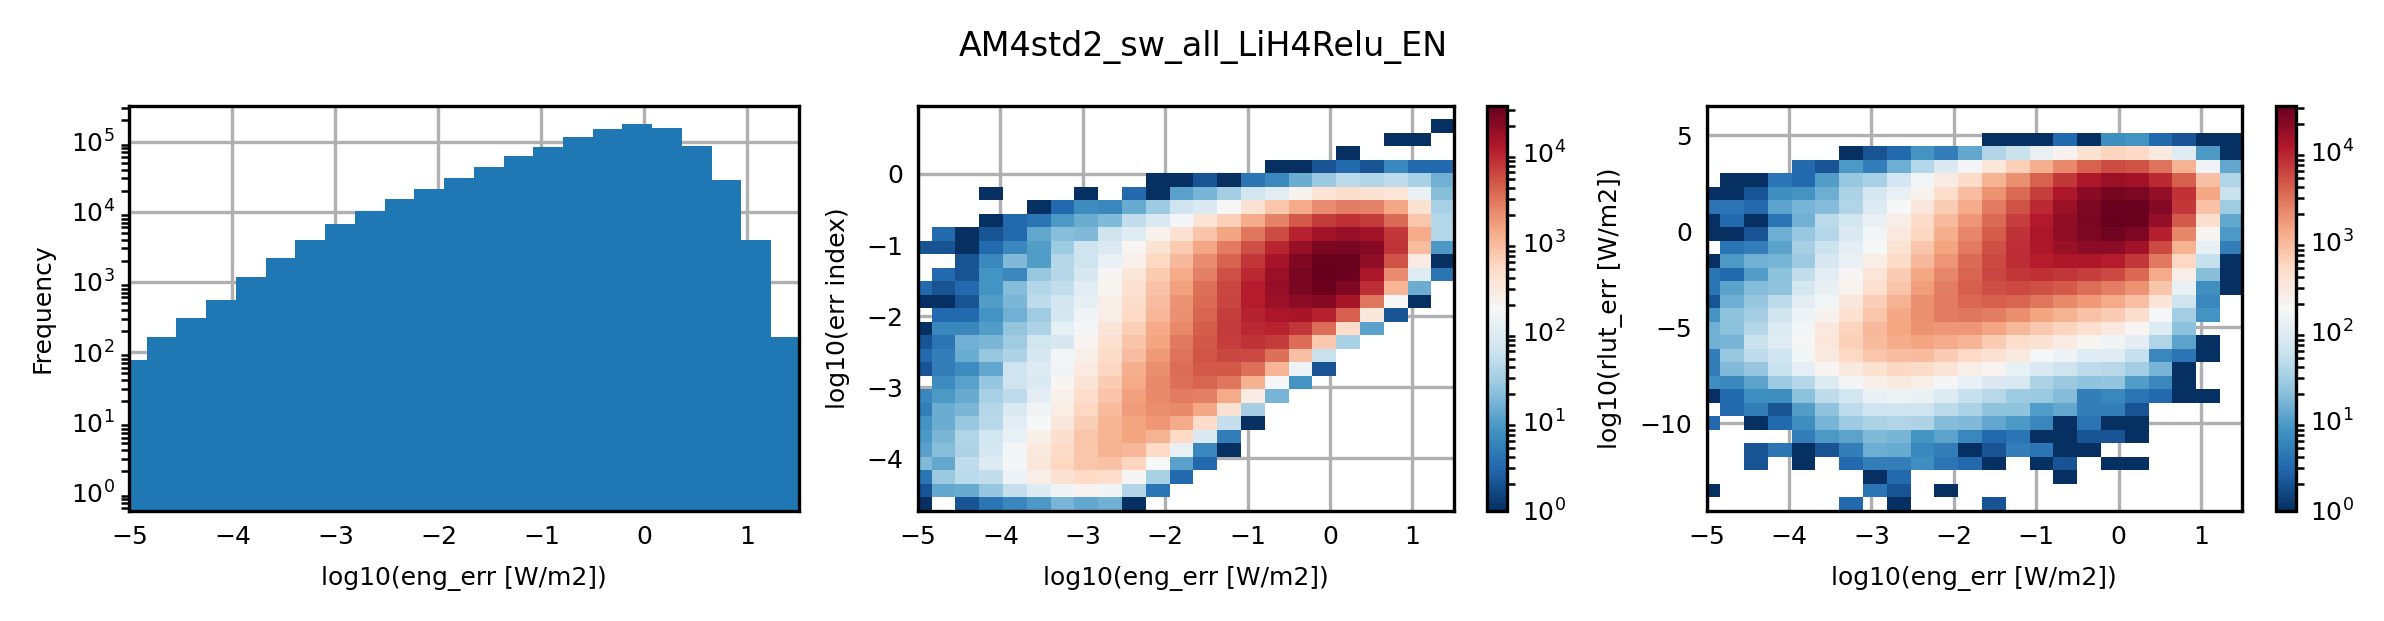

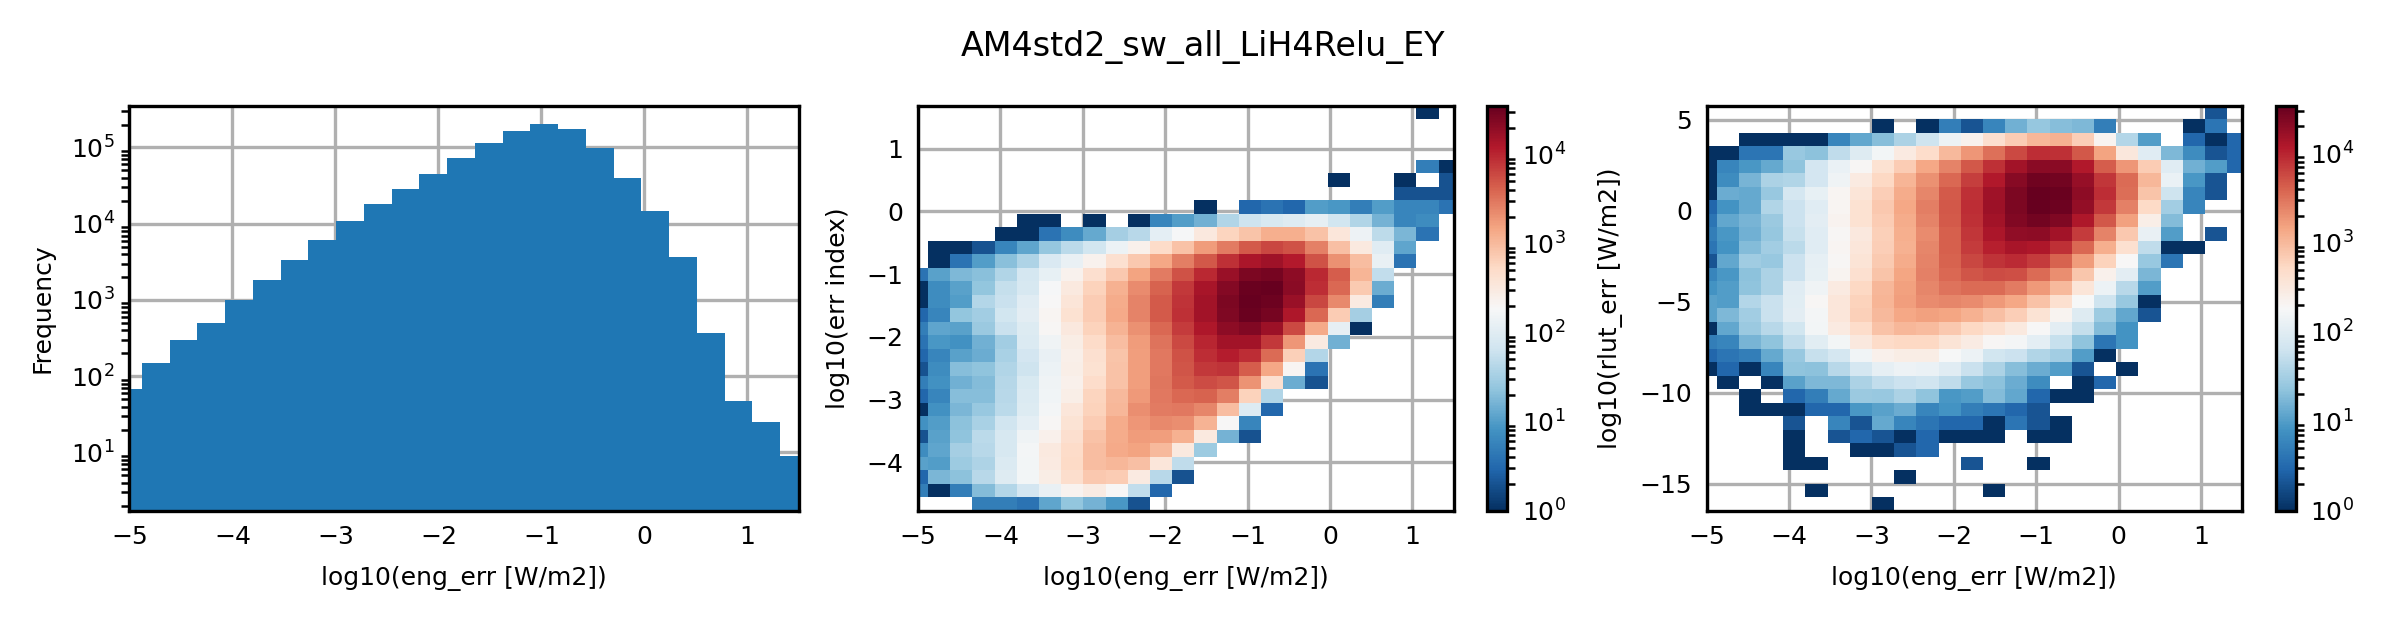

In [17]:
for i, mo in enumerate(Exp_name): 
    day_ind = day_inds[mo] 
    rd_id_more = np.random.randint(0,day_ind.shape[0],1000000)
    rd_id_more = day_ind[rd_id_more]
    std_nor = var_arr[mo][rd_id_more].std(axis=0)[None,:] 
    pred_err_ind = abs(error[mo][rd_id_more]/std_nor).mean(axis=1)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300, tight_layout=True) 
    axs= axs.flatten()
    ax = axs[0]
    eng_err_log = np.log(abs(eng_err_arr[mo][rd_id_more])+1e-6)/np.log(10)
    pred_err_ind_log = np.log(abs(pred_err_ind)+1e-6)/np.log(10)
    ax.hist(eng_err_log,bins=30)
    ax.set_yscale('log')
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('Frequency')
    ax = axs[1]
    h=ax.hist2d(eng_err_log,pred_err_ind_log, bins=30, 
                norm=colors.LogNorm(),cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('log10(err index)')
    ax = axs[2]
    h=ax.hist2d(eng_err_log,np.log(abs(error[mo][rd_id_more,0]+1e-6)/np.log(10)),
               bins=30, norm=colors.LogNorm(),cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('log10(rlut_err [W/m2])')
    plt.suptitle(mo,fontsize=8) 
    fig.show()